In [ ]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-06-01"
# end_time = "2022-04-01"
begin_time = "2016-01-01"
end_time = "2016-12-31"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 120
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_16.1.1-12.31.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

In [ ]:
from normalized_sliding_window_chan import NormalizedSlidingWindowChan

from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE
import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-06-01"
# end_time = "2022-04-01"
begin_time = "2018-01-01"
end_time = "2018-12-31"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: NormalizedSlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection with normalization.
    """
    print(f"[⏳] STEP 1: Running step load with normalized sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    print(f"[🧮] Normalization: {chan.normalization_type} ({'window' if chan.window_normalization else 'global'})")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Normalized Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    print(f"  Normalization type: {stats['normalization_type']}")
    print(f"  Window normalization: {stats['window_normalization']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 120
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp', 'price_pattern']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction', 'price_pattern']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")

    # Display normalized feature analysis
    norm_features = [col for col in df.columns if col.startswith('norm_')]
    if norm_features:
        print(f"\n  Normalized Features Analysis:")
        print(f"    Number of normalized features: {len(norm_features)}")
        print(f"    Example normalized features: {norm_features[:5]}")
        
        # Basic stats for normalized features
        for feature in norm_features[:3]:  # Show stats for first few features
            if feature in df.columns:
                feature_data = df[feature].dropna()
                if len(feature_data) > 0:
                    print(f"    {feature}: mean={feature_data.mean():.2f}, std={feature_data.std():.2f}, min={feature_data.min():.2f}, max={feature_data.max():.2f}")
    
    # Display pattern feature analysis
    pattern_features = [col for col in df.columns if col in [
        'price_direction', 'pct_change', 'log_return', 'price_pattern', 
        'trend_strength', 'trend_direction'
    ]]
    
    if pattern_features:
        print(f"\n  Pattern Features Analysis:")
        print(f"    Number of pattern features: {len(pattern_features)}")
        
        # Show distribution for categorical pattern features
        if 'price_pattern' in df.columns:
            pattern_counts = df['price_pattern'].value_counts().head(5)
            print(f"    Top 5 price patterns:")
            for pattern, count in pattern_counts.items():
                print(f"      {pattern}: {count} ({count/len(df)*100:.1f}%)")


def export_testing_dataset(
    chan: NormalizedSlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic and normalization.
    """
    print(f"[📊] Generating normalized testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Normalized sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved normalized testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating NORMALIZED TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 120,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create normalized sliding window Chan
        chan = NormalizedSlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000,
            normalization_type='z-score',  # 'z-score', 'minmax', or 'percentage'
            window_normalization=True,     # Use window-based normalization
            window_size=50                 # Window size for normalization stats calculation
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_normalized_testing_dataset_16.1.1-12.31.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of normalized testing data:")
            
            # Include both original and normalized features in sample
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'norm_close', 'norm_rsi',
                         'price_pattern', 'profit_target_pct', 'has_profit_target']
            
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(10))
            
            # Count normalized features
            norm_features = [col for col in df.columns if col.startswith('norm_')]
            pattern_features = [col for col in df.columns if col in [
                'price_direction', 'pct_change', 'log_return', 'price_pattern', 
                'trend_strength', 'trend_direction'
            ]]
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Normalized Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Normalized features: {len(norm_features)} normalized features added")
            print(f"  ✅ Pattern features: {len(pattern_features)} pattern-specific features added")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_normalized_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Normalized Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("NORMALIZATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: {stats['normalization_type']} normalization\n")
                f.write(f"Window-based: {stats['window_normalization']}\n")
                if stats['window_normalization']:
                    f.write(f"Window size: {stats['normalization_window_size']} K-lines\n")
                f.write(f"Normalized features: {len(norm_features)}\n")
                f.write(f"Pattern features: {len(pattern_features)}\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Normalized testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ NORMALIZED data for pattern recognition")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ Pattern-specific features for trend detection")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing and year-to-year comparison")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Normalized Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        # Count normalized features by type
        norm_price_features = [col for col in testing_data.columns if col.startswith('norm_') and any(f in col for f in ['open', 'high', 'low', 'close'])]
        norm_indicator_features = [col for col in testing_data.columns if col.startswith('norm_') and any(f in col for f in ['rsi', 'macd', 'kdj', 'dmi'])]
        pattern_features = [col for col in testing_data.columns if col in ['price_direction', 'pct_change', 'log_return', 'price_pattern', 'trend_strength', 'trend_direction']]
        
        print(f"\n[📊] Normalized Features Summary:")
        print(f"  ✅ Price features: {len(norm_price_features)}")
        print(f"  ✅ Indicator features: {len(norm_indicator_features)}")
        print(f"  ✅ Pattern features: {len(pattern_features)}")
        print(f"  ✅ Total features: {testing_data.shape[1]}")
        
        print(f"\n[💯] This normalized dataset is ideal for:")
        print(f"  ✅ Year-to-year pattern comparison")
        print(f"  ✅ Detecting repeating market regimes")
        print(f"  ✅ Building models that work across different price levels")
        print(f"  ✅ Pattern-based trading strategies")
    else:
        print("[❌] No normalized testing data was generated.")

In [ ]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-03-01"
# end_time = "2022-06-01"
begin_time = "2016-01-01"
end_time = "2016-12-31"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 288
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_16.1.1-12.31.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

In [ ]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-04-01"
# end_time = "2022-07-01"
begin_time = "2022-07-02"
end_time = "2022-07-30"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 288
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_22.7.2-7.30.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h2_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

In [ ]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-05-01"
# end_time = "2022-08-01"
begin_time = "2022-08-02"
end_time = "2022-08-30"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 288
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_22.8.2-8.30.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

In [ ]:
# ============================================================
# Daily Chan BSP plotter (Jupyter single cell)
# - Loads DAILY CSV (e.g., DataAPI/data/QQQ_DAY.csv)
# - Feeds bars into SlidingWindowChan (KL_TYPE.K_DAY)
# - Collects ALL BSPoints produced by the daily chan
# - Plots Close price + BSP markers over a chosen time window
#
# Requirements (your repo in PYTHONPATH):
#   sliding_window_chan.py, ChanConfig.py, Common/CEnum.py,
#   KLine/KLine_Unit.py, Common/CTime.py
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Any, List, Optional, Tuple

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import DATA_FIELD, KL_TYPE, AUTYPE, DATA_SRC
from KLine.KLine_Unit import CKLine_Unit
from Common.CTime import CTime


# ----------------------------
# Helpers
# ----------------------------

def to_ctime(ts) -> CTime:
    if isinstance(ts, CTime):
        return ts
    dt = pd.to_datetime(ts).to_pydatetime()
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, auto=False)
    except Exception:
        pass
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    except Exception:
        pass
    s = dt.strftime("%Y-%m-%d %H:%M:%S")
    try:
        return CTime(s, auto=False)
    except Exception:
        return CTime(s)

def build_klu(ts, o, h, l, c, v=0.0) -> CKLine_Unit:
    ct = to_ctime(ts)
    kl_dict = {
        DATA_FIELD.FIELD_TIME: ct,
        DATA_FIELD.FIELD_OPEN: float(o),
        DATA_FIELD.FIELD_HIGH: float(h),
        DATA_FIELD.FIELD_LOW:  float(l),
        DATA_FIELD.FIELD_CLOSE: float(c),
        DATA_FIELD.FIELD_VOLUME: float(v),
        "time": ct, "timestamp": ct, "datetime": ct, "dt": ct,
        "open": float(o), "high": float(h), "low": float(l), "close": float(c),
        "volume": float(v),
    }
    klu = CKLine_Unit(kl_dict)
    try:
        klu.time = ct
    except Exception:
        pass
    return klu

def _pick_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = list(df.columns)
    # exact match
    for c in candidates:
        if c in cols:
            return c
    # case-insensitive match
    lower_map = {c.lower(): c for c in cols}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

def load_daily_csv(daily_csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(daily_csv_path)

    ts_col = _pick_col(df, ["timestamp", "date", "datetime", "time"])
    if ts_col is None:
        ts_col = df.columns[0]

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).reset_index(drop=True)
    df = df.rename(columns={ts_col: "timestamp"})

    open_col  = _pick_col(df, ["open", "Open"])
    high_col  = _pick_col(df, ["high", "High"])
    low_col   = _pick_col(df, ["low", "Low"])
    close_col = _pick_col(df, ["close", "Close", "adj_close", "Adj Close", "AdjClose"])

    if open_col is None or close_col is None:
        raise ValueError("Daily CSV must contain open and close columns.")
    if high_col is None:
        high_col = close_col
    if low_col is None:
        low_col = close_col

    vol_col = _pick_col(df, ["volume", "Volume", "vol", "Vol"])

    df["_open"]  = pd.to_numeric(df[open_col], errors="coerce")
    df["_high"]  = pd.to_numeric(df[high_col], errors="coerce")
    df["_low"]   = pd.to_numeric(df[low_col], errors="coerce")
    df["_close"] = pd.to_numeric(df[close_col], errors="coerce")
    df["_vol"]   = pd.to_numeric(df[vol_col], errors="coerce") if vol_col is not None else 0.0

    df = df.dropna(subset=["_open", "_high", "_low", "_close"]).reset_index(drop=True)
    return df


# ----------------------------
# Main: run daily chan + plot BSPs
# ----------------------------

def plot_daily_chan_bspoints(
    daily_csv_path: str,
    code: str = "QQQ",
    daily_chan_start: str = "2018-06-01",  # start feeding chan from here (for enough history)
    plot_start: str = "2019-01-01",        # plot window start
    plot_end: str   = "2019-12-31",        # plot window end
    daily_chan_max_klines: int = 600,      # max kline stored inside SlidingWindowChan
    verbose: bool = True,
):
    df = load_daily_csv(daily_csv_path)

    start_dt = pd.to_datetime(daily_chan_start)
    plot_s = pd.to_datetime(plot_start)
    plot_e = pd.to_datetime(plot_end) + pd.Timedelta(hours=23, minutes=59, seconds=59)

    df = df[(df["timestamp"] >= start_dt)].copy().reset_index(drop=True)
    if df.empty:
        raise ValueError("No daily bars after daily_chan_start. Check your date range / CSV.")

    config = CChanConfig({
        "cal_demark": True,
        "cal_kdj": True,
        "cal_dmi": True,
        "cal_rsi": True,
        "cal_rsl": True,
        "cal_demand_index": True,
        "cal_adline": True,
        "cal_bb_vals": True,
        "cal_kc_vals": True,
        "cal_starc_vals": True,
        "bi_strict": True,
        "trigger_step": True,
        "skip_step": 0,
        "divergence_rate": float("inf"),
        "bsp2_follow_1": True,
        "bsp3_follow_1": False,
        "min_zs_cnt": 0,
        "bs1_peak": False,
        "macd_algo": "peak",
        "bs_type": "1,2,3a,1p,2s,3b",
        "print_warning": False,
        "zs_algo": "normal",
    })

    daily_chan = SlidingWindowChan(
        code=code,
        begin_time=None,
        end_time=None,
        data_src=DATA_SRC.CSV,
        lv_list=[KL_TYPE.K_DAY],
        config=config,
        autype=AUTYPE.QFQ,
        max_klines=int(daily_chan_max_klines),
    )

    bsp_rows: List[Dict[str, Any]] = []
    seen = set()

    for i in range(len(df)):
        ts = df.loc[i, "timestamp"]
        klu = build_klu(
            ts=ts,
            o=float(df.loc[i, "_open"]),
            h=float(df.loc[i, "_high"]),
            l=float(df.loc[i, "_low"]),
            c=float(df.loc[i, "_close"]),
            v=float(df.loc[i, "_vol"]) if "_vol" in df.columns else 0.0,
        )

        daily_chan.process_new_kline(klu)

        new_bsp = daily_chan.export_new_historical_bsp_to_list()
        if not new_bsp:
            continue

        # Each exported BSP may not carry full timestamp the way we want;
        # we attach the current bar timestamp as the "seen time".
        for r0 in new_bsp:
            r = dict(r0)
            r.setdefault("timestamp", ts)

            # normalize direction
            if "direction" not in r or r["direction"] is None:
                if r.get("is_buy", None) is not None:
                    r["direction"] = "buy" if bool(r["is_buy"]) else "sell"
                else:
                    r["direction"] = "buy"
            r["direction"] = str(r["direction"]).lower()

            # normalize type as string
            if "bsp_type" in r and r["bsp_type"] is not None:
                r["bsp_type"] = str(r["bsp_type"]).lower()
            else:
                r["bsp_type"] = "?"

            # de-dupe key
            key = (pd.to_datetime(r["timestamp"]).strftime("%Y-%m-%d"), int(r.get("klu_idx", -1)), r["direction"], r["bsp_type"])
            if key in seen:
                continue
            seen.add(key)
            bsp_rows.append(r)

    bsp_df = pd.DataFrame(bsp_rows)
    if bsp_df.empty:
        if verbose:
            print("No BSPoints were produced by daily chan for this range.")
        # still show price plot
        df_plot = df[(df["timestamp"] >= plot_s) & (df["timestamp"] <= plot_e)].copy()
        plt.figure(figsize=(16, 7))
        plt.plot(df_plot["timestamp"], df_plot["_close"], linewidth=1.0)
        plt.title(f"{code} DAILY Close (no BSPoints found in feed range)")
        plt.tight_layout()
        plt.show()
        return bsp_df

    bsp_df["timestamp"] = pd.to_datetime(bsp_df["timestamp"], errors="coerce")
    bsp_df = bsp_df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    # Plot window
    df_plot = df[(df["timestamp"] >= plot_s) & (df["timestamp"] <= plot_e)].copy()
    bsp_plot = bsp_df[(bsp_df["timestamp"] >= plot_s) & (bsp_df["timestamp"] <= plot_e)].copy()

    # Map BSP timestamp -> close price (daily close at that date)
    close_map = df.set_index(df["timestamp"].dt.normalize())["_close"].to_dict()
    bsp_plot["px"] = bsp_plot["timestamp"].dt.normalize().map(close_map)
    bsp_plot = bsp_plot.dropna(subset=["px"])

    # Plot
    plt.figure(figsize=(16, 7))
    plt.plot(df_plot["timestamp"], df_plot["_close"], linewidth=1.0, label="Daily Close")

    buy_mask = bsp_plot["direction"] == "buy"
    sell_mask = bsp_plot["direction"] == "sell"

    if buy_mask.any():
        plt.scatter(bsp_plot.loc[buy_mask, "timestamp"], bsp_plot.loc[buy_mask, "px"], marker="^", s=90, label="BSP BUY")
    if sell_mask.any():
        plt.scatter(bsp_plot.loc[sell_mask, "timestamp"], bsp_plot.loc[sell_mask, "px"], marker="v", s=90, label="BSP SELL")

    # Light annotations (type)
    # (keep it readable: annotate only if not too many points)
    if len(bsp_plot) <= 120:
        for _, r in bsp_plot.iterrows():
            txt = f"{r.get('bsp_type','?')}"
            plt.annotate(txt, (r["timestamp"], r["px"]), textcoords="offset points", xytext=(0, 8), ha="center", fontsize=8)

    plt.title(f"{code} DAILY Chan BSPoints ({plot_start} → {plot_end}) | feed_start={daily_chan_start}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"BSPoints total (feed range): {len(bsp_df)}")
        print(f"BSPoints in plot window: {len(bsp_plot)}")
        print("Columns:", list(bsp_df.columns))

    return bsp_df


# ============================================================
# RUN (edit here)
# ============================================================

bsp_df = plot_daily_chan_bspoints(
    daily_csv_path="DataAPI/data/QQQ_DAY.csv",
    code="QQQ",
    daily_chan_start="2015-06-01",
    plot_start="2015-09-01",
    plot_end="2024-12-31",
    daily_chan_max_klines=600,
    verbose=True,
)

# Optional: inspect the BSP table
display(bsp_df.head(30))


In [ ]:
# ============================================================
# Daily Chan BSP "Reversal Soon" Probability (Jupyter SINGLE CELL) - KeyError-proof + small-class safe
#
# Label rule (your new rule):
#   For BSP i: y=1 if NEXT BSP is opposite direction and occurs within H calendar days.
#   Else y=0. Last BSP is unlabeled (NaN).
#
# Two complementary online models (walk-forward):
#   A) BSP-event model: uses chan-exported numeric fields (whatever exists) + BSP density + volume shocks
#   B) Kline-dense model: uses raw daily bar features; label is "will opposite BSP happen within H days"
# Fusion for each BSP:
#   p = w_bsp * p_bsp + (1-w_bsp) * p_kline
#
# Fix included:
#   CalibratedClassifierCV now adapts cv based on class counts; falls back to plain LR if too few.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Any, List, Optional
from dataclasses import dataclass

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import DATA_FIELD, KL_TYPE, AUTYPE

try:
    from Common.CEnum import DATA_SRC
except Exception:
    class DATA_SRC:
        CSV = "CSV"

from KLine.KLine_Unit import CKLine_Unit
from Common.CTime import CTime


# ----------------------------
# Chan bar builders
# ----------------------------

def to_ctime(ts) -> CTime:
    if isinstance(ts, CTime):
        return ts
    dt = pd.to_datetime(ts).to_pydatetime()
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, auto=False)
    except Exception:
        pass
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    except Exception:
        pass
    s = dt.strftime("%Y-%m-%d %H:%M:%S")
    try:
        return CTime(s, auto=False)
    except Exception:
        return CTime(s)

def build_klu(ts, o, h, l, c, v=0.0) -> CKLine_Unit:
    ct = to_ctime(ts)
    kl_dict = {
        DATA_FIELD.FIELD_TIME: ct,
        DATA_FIELD.FIELD_OPEN: float(o),
        DATA_FIELD.FIELD_HIGH: float(h),
        DATA_FIELD.FIELD_LOW:  float(l),
        DATA_FIELD.FIELD_CLOSE: float(c),
        DATA_FIELD.FIELD_VOLUME: float(v),
        "time": ct, "timestamp": ct, "datetime": ct, "dt": ct,
        "open": float(o), "high": float(h), "low": float(l), "close": float(c),
        "volume": float(v),
    }
    klu = CKLine_Unit(kl_dict)
    try:
        klu.time = ct
    except Exception:
        pass
    return klu


# ----------------------------
# CSV loader
# ----------------------------

def _pick_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = list(df.columns)
    for c in candidates:
        if c in cols:
            return c
    lower_map = {c.lower(): c for c in cols}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

def load_daily_csv(daily_csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(daily_csv_path)

    ts_col = _pick_col(df, ["timestamp", "date", "datetime", "time"])
    if ts_col is None:
        ts_col = df.columns[0]

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).reset_index(drop=True)
    df = df.rename(columns={ts_col: "timestamp"})

    open_col  = _pick_col(df, ["open", "Open", "o", "O"])
    high_col  = _pick_col(df, ["high", "High", "h", "H"])
    low_col   = _pick_col(df, ["low", "Low", "l", "L"])
    close_col = _pick_col(df, ["close", "Close", "adj_close", "Adj Close", "AdjClose", "c", "C"])
    if open_col is None or close_col is None:
        raise ValueError("Daily CSV must contain open and close columns.")
    if high_col is None:
        high_col = close_col
    if low_col is None:
        low_col = close_col

    vol_col = _pick_col(df, ["volume", "Volume", "vol", "Vol", "v", "V"])

    df["_open"]  = pd.to_numeric(df[open_col], errors="coerce").astype(float)
    df["_high"]  = pd.to_numeric(df[high_col], errors="coerce").astype(float)
    df["_low"]   = pd.to_numeric(df[low_col], errors="coerce").astype(float)
    df["_close"] = pd.to_numeric(df[close_col], errors="coerce").astype(float)
    df["_vol"]   = pd.to_numeric(df[vol_col], errors="coerce").astype(float) if vol_col is not None else 0.0

    df = df.dropna(subset=["_open", "_high", "_low", "_close"]).reset_index(drop=True)
    df["ts_norm"] = df["timestamp"].dt.normalize()
    return df


# ----------------------------
# Kline features (dense)
# ----------------------------

def _safe_div(a, b, eps=1e-12):
    return a / (b + eps)

def compute_kline_features(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy().sort_values("timestamp").reset_index(drop=True)

    o = d["_open"].astype(float)
    h = d["_high"].astype(float)
    l = d["_low"].astype(float)
    c = d["_close"].astype(float)
    v = d["_vol"].astype(float)

    prev_c = c.shift(1)
    d["ret1"] = (_safe_div(c, prev_c) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    tr = pd.concat([(h-l).abs(), (h-prev_c).abs(), (l-prev_c).abs()], axis=1).max(axis=1)
    d["tr"] = tr.fillna(0.0)
    d["atr_14"] = d["tr"].rolling(14).mean().fillna(method="bfill").fillna(0.0)

    d["range"] = (h - l).fillna(0.0)
    d["range_over_atr"] = _safe_div(d["range"], d["atr_14"]).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    rng = (h - l).replace(0.0, np.nan)
    d["close_pos"] = ((c - l) / rng).replace([np.inf, -np.inf], np.nan).fillna(0.5)

    d["gap"] = (_safe_div(o, prev_c) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [5, 10, 20, 40]:
        d[f"ret_{w}"] = (_safe_div(c, c.shift(w)) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        d[f"vol_{w}"] = d["ret1"].rolling(w).std().replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [20, 50, 100]:
        ma = c.rolling(w).mean()
        d[f"above_ma_{w}"] = (_safe_div(c, ma) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [5, 20, 60]:
        m = v.rolling(w).mean()
        s = v.rolling(w).std()
        d[f"vol_ratio_{w}"] = _safe_div(v, m).replace([np.inf, -np.inf], np.nan).fillna(1.0)
        d[f"vol_z_{w}"] = ((v - m) / (s + 1e-12)).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    d["vol_jump"] = _safe_div(v, v.shift(1)).replace([np.inf, -np.inf], np.nan).fillna(1.0)

    def _slope_log(x):
        x = np.asarray(x, dtype=float)
        x = np.log(np.maximum(x, 1e-12))
        t = np.arange(len(x), dtype=float)
        t = t - t.mean()
        x = x - x.mean()
        den = (t*t).sum()
        return 0.0 if den <= 0 else float((t*x).sum() / den)

    d["slope40"] = d["_close"].rolling(40).apply(_slope_log, raw=False).fillna(0.0)

    return d


# ----------------------------
# BSP normalize + features
# ----------------------------

def normalize_bsp_row(r: Dict[str, Any]) -> Dict[str, Any]:
    rr = dict(r)
    if "direction" not in rr or rr["direction"] is None:
        if rr.get("is_buy", None) is not None:
            rr["direction"] = "buy" if bool(rr["is_buy"]) else "sell"
        else:
            rr["direction"] = "buy"
    rr["direction"] = str(rr["direction"]).lower()

    if "bsp_type" in rr and rr["bsp_type"] is not None:
        rr["bsp_type"] = str(rr["bsp_type"]).lower()
    else:
        rr["bsp_type"] = "?"
    return rr

def extract_bsp_rows_from_chan(chan_obj) -> List[Dict[str, Any]]:
    if hasattr(chan_obj, "export_new_historical_bsp_to_list"):
        out = chan_obj.export_new_historical_bsp_to_list()
        return out if out else []
    return []

def make_bsp_context_features(
    bsp_hist: List[Dict[str, Any]],
    cur_ts: pd.Timestamp,
    direction: str,
    k: int = 7,
    window_days: int = 60,
) -> Dict[str, float]:
    past = [r for r in bsp_hist if pd.to_datetime(r["timestamp"]) < cur_ts]
    past = sorted(past, key=lambda x: pd.to_datetime(x["timestamp"]))
    if not past:
        return {
            "ctx_lastk_same": 0.0, "ctx_lastk_opp": 0.0, "ctx_lastk_imb": 0.0,
            "ctx_days_since_same": 999.0, "ctx_days_since_opp": 999.0,
            "ctx_density_total": 0.0, "ctx_density_same": 0.0, "ctx_density_opp": 0.0
        }

    lastk = past[-k:]
    same = sum(1 for r in lastk if str(r.get("direction","")).lower() == direction)
    oppd = "sell" if direction == "buy" else "buy"
    opp = sum(1 for r in lastk if str(r.get("direction","")).lower() == oppd)
    tot = max(1.0, float(same + opp))

    def _days_since(target_dir: str) -> float:
        for r in reversed(past):
            if str(r.get("direction","")).lower() == target_dir:
                return float((cur_ts.normalize() - pd.to_datetime(r["timestamp"]).normalize()).days)
        return 999.0

    start = cur_ts.normalize() - pd.Timedelta(days=int(window_days))
    recent = [r for r in past if pd.to_datetime(r["timestamp"]).normalize() >= start]

    return {
        "ctx_lastk_same": float(same),
        "ctx_lastk_opp": float(opp),
        "ctx_lastk_imb": float((opp - same) / tot),
        "ctx_days_since_same": _days_since(direction),
        "ctx_days_since_opp":  _days_since(oppd),
        "ctx_density_total": float(len(recent)),
        "ctx_density_same":  float(sum(1 for r in recent if str(r.get("direction","")).lower() == direction)),
        "ctx_density_opp":   float(sum(1 for r in recent if str(r.get("direction","")).lower() == oppd)),
    }

KLINE_KEYS = [
    "ret1","ret_5","ret_10","ret_20","ret_40",
    "vol_5","vol_10","vol_20","vol_40",
    "atr_14","range_over_atr","close_pos","gap",
    "vol_ratio_5","vol_ratio_20","vol_ratio_60",
    "vol_z_20","vol_z_60","vol_jump",
    "above_ma_20","above_ma_50","above_ma_100",
    "slope40",
]

def make_kline_dict(kline_row: pd.Series) -> Dict[str, float]:
    d = {}
    for k in KLINE_KEYS:
        val = kline_row[k] if k in kline_row.index else 0.0
        d[f"k_{k}"] = float(val) if np.isfinite(val) else 0.0
    return d

def make_bsp_event_features(
    bsp_row: Dict[str, Any],
    kline_row: pd.Series,
    bsp_hist: List[Dict[str, Any]],
) -> Dict[str, float]:
    rr = normalize_bsp_row(bsp_row)
    ts = pd.to_datetime(rr["timestamp"])
    direction = rr["direction"]
    bsp_type = rr.get("bsp_type", "?")

    feats: Dict[str, float] = {}
    feats["dir_buy"] = 1.0 if direction == "buy" else 0.0
    feats["dir_sell"] = 1.0 if direction == "sell" else 0.0
    feats[f"type_{bsp_type}"] = 1.0

    # Any numeric chan field that exists (safe)
    for k, v in rr.items():
        if k in ("timestamp", "direction", "bsp_type"):
            continue
        if isinstance(v, (int, float, np.integer, np.floating)) and np.isfinite(float(v)):
            feats[f"chan_{k}"] = float(v)

    feats.update(make_bsp_context_features(bsp_hist, ts, direction, k=7, window_days=60))

    # include kline context on BSP day
    kd = make_kline_dict(kline_row)
    feats.update(kd)

    return feats


# ----------------------------
# Model helpers (small-class safe calibration)
# ----------------------------

def fit_dict_prob_model(X_dicts: List[Dict[str, float]], y: np.ndarray) -> Pipeline:
    # Build vectorizer
    vec = DictVectorizer(sparse=True)
    X = vec.fit_transform(X_dicts)

    # Base model
    lr = LogisticRegression(max_iter=4000, class_weight="balanced", solver="lbfgs")

    # If only one class exists, can't train a classifier
    uniq, counts = np.unique(y, return_counts=True)
    if len(uniq) < 2:
        raise ValueError("Only one class in y so far; wait for more labels before training.")

    min_count = int(counts.min())

    # Adaptive calibration
    if min_count >= 5:
        cal = CalibratedClassifierCV(lr, method="sigmoid", cv=3)
        cal.fit(X, y)
        return Pipeline([("vec", vec), ("model", cal)])
    elif min_count >= 3:
        cal = CalibratedClassifierCV(lr, method="sigmoid", cv=2)
        cal.fit(X, y)
        return Pipeline([("vec", vec), ("model", cal)])
    else:
        # too few positives/negatives for calibration -> use plain LR
        lr.fit(X, y)
        return Pipeline([("vec", vec), ("model", lr)])

def predict_dict_prob(pipe: Pipeline, X_dicts: List[Dict[str, float]]) -> np.ndarray:
    vec = pipe.named_steps["vec"]
    mdl = pipe.named_steps["model"]
    X = vec.transform(X_dicts)
    if hasattr(mdl, "predict_proba"):
        return mdl.predict_proba(X)[:, 1]
    # (shouldn't happen for LR)
    p = mdl.decision_function(X)
    return 1.0 / (1.0 + np.exp(-p))


@dataclass
class OnlineModelState:
    bsp_model: Optional[Pipeline] = None
    kline_model: Optional[Pipeline] = None
    trained_bsp: int = 0
    trained_kline: int = 0


# ----------------------------
# Main runner
# ----------------------------

def run_daily_chan_reversal_probability_plot(
    daily_csv_path: str,
    code: str = "QQQ",
    daily_chan_start: str = "2015-06-01",
    plot_start: str = "2018-09-01",
    plot_end: str   = "2024-12-31",
    daily_chan_max_klines: int = 800,

    H: int = 60,

    min_labeled_bsp_to_train: int = 40,
    retrain_every_new_bsp_labels: int = 25,
    min_labeled_kline_to_train: int = 200,
    retrain_every_new_kline_labels: int = 150,

    w_bsp: float = 0.65,

    annotate_prob_th: float = 0.88,
    annotate_max_per_year: int = 10,
    jitter_hours: float = 36.0,

    verbose: bool = True,
):
    df = load_daily_csv(daily_csv_path)
    df = df[df["timestamp"] >= pd.to_datetime(daily_chan_start)].copy().reset_index(drop=True)
    if df.empty:
        raise ValueError("No daily bars after daily_chan_start. Check your CSV/date range.")

    df_feat = compute_kline_features(df)

    plot_s = pd.to_datetime(plot_start)
    plot_e = pd.to_datetime(plot_end) + pd.Timedelta(hours=23, minutes=59, seconds=59)

    config = CChanConfig({
        "cal_demark": True,
        "cal_kdj": True,
        "cal_dmi": True,
        "cal_rsi": True,
        "cal_rsl": True,
        "cal_demand_index": True,
        "cal_adline": True,
        "cal_bb_vals": True,
        "cal_kc_vals": True,
        "cal_starc_vals": True,
        "bi_strict": True,
        "trigger_step": True,
        "skip_step": 0,
        "divergence_rate": float("inf"),
        "bsp2_follow_1": True,
        "bsp3_follow_1": False,
        "min_zs_cnt": 0,
        "bs1_peak": False,
        "macd_algo": "peak",
        "bs_type": "1,2,3a,1p,2s,3b",
        "print_warning": False,
        "zs_algo": "normal",
    })

    daily_chan = SlidingWindowChan(
        code=code,
        begin_time=None,
        end_time=None,
        data_src=getattr(DATA_SRC, "CSV", "CSV"),
        lv_list=[KL_TYPE.K_DAY],
        config=config,
        autype=AUTYPE.QFQ,
        max_klines=int(daily_chan_max_klines),
    )

    bsp_rows: List[Dict[str, Any]] = []
    seen = set()

    last_unlabeled_bsp_idx: Optional[int] = None

    bsp_X: List[Dict[str, float]] = []
    bsp_y: List[int] = []
    new_bsp_labels = 0

    k_X: List[Dict[str, float]] = []
    k_y: List[int] = []
    new_kline_labels = 0
    pending_kline_days: List[int] = []

    ms = OnlineModelState()

    def maybe_train():
        nonlocal new_bsp_labels, new_kline_labels

        # BSP model
        if len(bsp_y) >= min_labeled_bsp_to_train and (ms.bsp_model is None or new_bsp_labels >= retrain_every_new_bsp_labels):
            y = np.asarray(bsp_y, dtype=int)
            # only train if both classes exist
            if len(np.unique(y)) >= 2:
                try:
                    ms.bsp_model = fit_dict_prob_model(bsp_X, y)
                    ms.trained_bsp = len(y)
                    if verbose:
                        print(f"[TRAIN][BSP] n={len(y)} pos={int(y.sum())} ({y.mean():.2%})")
                    new_bsp_labels = 0
                except ValueError as e:
                    if verbose:
                        print(f"[TRAIN][BSP] skipped: {e}")

        # Kline model
        if len(k_y) >= min_labeled_kline_to_train and (ms.kline_model is None or new_kline_labels >= retrain_every_new_kline_labels):
            y = np.asarray(k_y, dtype=int)
            if len(np.unique(y)) >= 2:
                try:
                    ms.kline_model = fit_dict_prob_model(k_X, y)
                    ms.trained_kline = len(y)
                    if verbose:
                        print(f"[TRAIN][KLINE] n={len(y)} pos={int(y.sum())} ({y.mean():.2%})")
                    new_kline_labels = 0
                except ValueError as e:
                    if verbose:
                        print(f"[TRAIN][KLINE] skipped: {e}")

    def predict_p(feat_bsp: Dict[str, float], feat_k: Dict[str, float]) -> Optional[float]:
        pb = None
        pk = None
        if ms.bsp_model is not None:
            pb = float(predict_dict_prob(ms.bsp_model, [feat_bsp])[0])
        if ms.kline_model is not None:
            pk = float(predict_dict_prob(ms.kline_model, [feat_k])[0])
        if pb is None and pk is None:
            return None
        if pb is None:
            return pk
        if pk is None:
            return pb
        return float(w_bsp * pb + (1.0 - w_bsp) * pk)

    def latest_bsp_dir_up_to(ts: pd.Timestamp) -> Optional[str]:
        past = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= ts]
        if not past:
            return None
        past = sorted(past, key=lambda x: pd.to_datetime(x["timestamp"]))
        return str(past[-1].get("direction","")).lower()

    def will_opposite_bsp_occur(t0: pd.Timestamp, base_dir: str, t1: pd.Timestamp) -> int:
        opp = "sell" if base_dir == "buy" else "buy"
        for r in bsp_rows:
            tr = pd.to_datetime(r["timestamp"])
            if t0 < tr <= t1 and str(r.get("direction","")).lower() == opp:
                return 1
        return 0

    # Walk-forward daily
    for i in range(len(df_feat)):
        ts = pd.to_datetime(df_feat.loc[i, "timestamp"])

        daily_chan.process_new_kline(build_klu(
            ts=ts,
            o=float(df_feat.loc[i, "_open"]),
            h=float(df_feat.loc[i, "_high"]),
            l=float(df_feat.loc[i, "_low"]),
            c=float(df_feat.loc[i, "_close"]),
            v=float(df_feat.loc[i, "_vol"]),
        ))

        pending_kline_days.append(i)

        # Label kline day j when i reaches j + H (daily bars approx)
        while pending_kline_days and i >= pending_kline_days[0] + int(H):
            j = pending_kline_days.pop(0)
            t0 = pd.to_datetime(df_feat.loc[j, "timestamp"])
            t1 = pd.to_datetime(df_feat.loc[j + int(H), "timestamp"])
            base_dir = latest_bsp_dir_up_to(t0)
            if base_dir not in ("buy", "sell"):
                continue
            yk = will_opposite_bsp_occur(t0, base_dir, t1)
            k_X.append(make_kline_dict(df_feat.loc[j]))
            k_y.append(int(yk))
            new_kline_labels += 1

        new_bsp = extract_bsp_rows_from_chan(daily_chan)
        if not new_bsp:
            maybe_train()
            continue

        for r0 in new_bsp:
            r = normalize_bsp_row(dict(r0))
            r.setdefault("timestamp", ts)

            key = (pd.to_datetime(r["timestamp"]).strftime("%Y-%m-%d"), r["direction"], r.get("bsp_type","?"))
            if key in seen:
                continue
            seen.add(key)

            r["px_close"] = float(df_feat.loc[i, "_close"])

            krow = df_feat.loc[i]
            feat_bsp = make_bsp_event_features(r, krow, bsp_rows)
            feat_k = make_kline_dict(krow)

            p = predict_p(feat_bsp, feat_k)
            r["p_reversal_soon"] = float(p) if p is not None else np.nan

            bsp_rows.append(r)

            # label previous BSP when this arrives
            if last_unlabeled_bsp_idx is not None:
                prev = bsp_rows[last_unlabeled_bsp_idx]
                t_prev = pd.to_datetime(prev["timestamp"])
                t_now  = pd.to_datetime(r["timestamp"])
                delta_days = (t_now.normalize() - t_prev.normalize()).days

                y = 0
                if delta_days <= int(H):
                    if prev.get("direction") in ("buy","sell") and r.get("direction") in ("buy","sell") and prev["direction"] != r["direction"]:
                        y = 1
                prev["y_flip_soon"] = float(y)

                # training example for prev
                prev_day = t_prev.normalize()
                idxs = df_feat.index[df_feat["ts_norm"] == prev_day]
                j = int(idxs[0]) if len(idxs) else i
                krow_prev = df_feat.loc[j]
                hist_before_prev = [x for x in bsp_rows if pd.to_datetime(x["timestamp"]) < t_prev]
                feat_prev = make_bsp_event_features(prev, krow_prev, hist_before_prev)

                bsp_X.append(feat_prev)
                bsp_y.append(int(y))
                new_bsp_labels += 1

                last_unlabeled_bsp_idx = len(bsp_rows) - 1
            else:
                last_unlabeled_bsp_idx = len(bsp_rows) - 1

            maybe_train()

    bsp_df = pd.DataFrame(bsp_rows)
    if bsp_df.empty:
        print("No BSPoints produced.")
        return bsp_df

    bsp_df["timestamp"] = pd.to_datetime(bsp_df["timestamp"], errors="coerce")
    bsp_df = bsp_df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    df_plot = df_feat[(df_feat["timestamp"] >= plot_s) & (df_feat["timestamp"] <= plot_e)].copy()
    bsp_plot = bsp_df[(bsp_df["timestamp"] >= plot_s) & (bsp_df["timestamp"] <= plot_e)].copy()

    close_map = df_feat.set_index("ts_norm")["_close"].to_dict()
    bsp_plot["px"] = bsp_plot["timestamp"].dt.normalize().map(close_map)
    bsp_plot = bsp_plot.dropna(subset=["px"]).reset_index(drop=True)

    plt.figure(figsize=(16, 8))
    plt.plot(df_plot["timestamp"], df_plot["_close"], linewidth=1.0, label="Daily Close")

    pvals = pd.to_numeric(bsp_plot["p_reversal_soon"], errors="coerce").fillna(-1.0).to_numpy()
    buy_mask = bsp_plot["direction"].astype(str).str.lower().eq("buy").to_numpy()
    sell_mask = bsp_plot["direction"].astype(str).str.lower().eq("sell").to_numpy()

    def colors(arr):
        out = []
        for x in arr:
            if x < 0:
                out.append((0.5, 0.5, 0.5, 0.6))
            else:
                out.append(plt.cm.viridis(float(np.clip(x, 0, 1))))
        return out

    if buy_mask.any():
        plt.scatter(
            bsp_plot.loc[buy_mask, "timestamp"],
            bsp_plot.loc[buy_mask, "px"],
            marker="^",
            s=80,
            c=colors(pvals[buy_mask]),
            edgecolors="none",
            label="BSP BUY (color=p)",
        )
    if sell_mask.any():
        plt.scatter(
            bsp_plot.loc[sell_mask, "timestamp"],
            bsp_plot.loc[sell_mask, "px"],
            marker="v",
            s=80,
            c=colors(pvals[sell_mask]),
            edgecolors="none",
            label="BSP SELL (color=p)",
        )

    ann = bsp_plot.copy()
    ann["p"] = pd.to_numeric(ann["p_reversal_soon"], errors="coerce")
    ann = ann.dropna(subset=["p"])
    ann = ann[ann["p"] >= float(annotate_prob_th)].copy()
    if not ann.empty:
        ann["year"] = ann["timestamp"].dt.year
        ann = ann.sort_values(["year","p"], ascending=[True, False]).groupby("year").head(int(annotate_max_per_year))
        ann = ann.reset_index(drop=True)
        ann["_rank"] = ann.groupby("year").cumcount()
        ann["_ts_jit"] = ann["timestamp"] + pd.to_timedelta(((ann["_rank"] % 7) - 3) * float(jitter_hours), unit="h")
        for _, r in ann.iterrows():
            plt.annotate(f"{float(r['p']):.2f}", (r["_ts_jit"], r["px"]), textcoords="offset points",
                         xytext=(0, 10), ha="center", fontsize=8, alpha=0.9)

    plt.title(
        f"{code} DAILY Chan BSPs with Reversal Probability (small-class safe)\n"
        f"Label: next BSP opposite within {H} days | fusion w_bsp={w_bsp:.2f} | feed_start={daily_chan_start}"
    )
    plt.legend()
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, pad=0.01)
    cbar.set_label("p(reversal soon)")

    plt.tight_layout()
    plt.show()

    if verbose:
        labeled = pd.to_numeric(bsp_df.get("y_flip_soon", np.nan), errors="coerce").dropna()
        pos = int((labeled == 1).sum()) if len(labeled) else 0
        print(f"[BSP] total={len(bsp_df)} labeled={len(labeled)} pos={pos} ({(pos/len(labeled)) if len(labeled) else 0:.2%})")
        print(f"[MODEL] bsp_model={'yes' if ms.bsp_model is not None else 'no'} trained_bsp={ms.trained_bsp}")
        print(f"[MODEL] kline_model={'yes' if ms.kline_model is not None else 'no'} trained_kline={ms.trained_kline}")

    return bsp_df


# ============================================================
# RUN
# ============================================================

bsp_df = run_daily_chan_reversal_probability_plot(
    daily_csv_path="DataAPI/data/QQQ_DAY.csv",
    code="QQQ",
    daily_chan_start="2016-06-01",
    plot_start="2018-09-01",
    plot_end="2020-12-31",
    daily_chan_max_klines=800,

    H=60,

    min_labeled_bsp_to_train=40,
    retrain_every_new_bsp_labels=25,
    min_labeled_kline_to_train=200,
    retrain_every_new_kline_labels=150,

    w_bsp=0.65,

    annotate_prob_th=0.88,
    annotate_max_per_year=10,
    jitter_hours=36.0,

    verbose=True,
)

display(bsp_df.head(30))


In [ ]:
# generate_testing_data_with_sliding_window_best24h.py
"""
Modified version of testing data generation that uses:
1. Sliding window for memory efficiency
2. BEST reverse signal within 24 hours (instead of just next reverse)
"""

import os
import pandas as pd
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from datetime import datetime

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import KL_TYPE, DATA_SRC, AUTYPE

# Setup recursion limit
sys.setrecursionlimit(30000)

# Configuration
test_ticker = "SPY"
# begin_time = "2022-06-01"
# end_time = "2022-09-01"
begin_time = "2022-09-02"
end_time = "2022-09-30"
lv_list = [KL_TYPE.K_5M]
lv = KL_TYPE.K_5M
data_src = DATA_SRC.CSV
autype = AUTYPE.QFQ

config = CChanConfig({
    "cal_demark": True,
    "cal_kdj": True,
    "cal_dmi": True,
    "cal_rsi": True,
    "cal_rsl": True,
    "cal_demand_index": True,
    "cal_adline": True,
    "cal_bb_vals": True,
    "cal_kc_vals": True,
    "cal_starc_vals": True,
    "bi_strict": True,
    "trigger_step": True,
    "skip_step": 0,
    "divergence_rate": float("inf"),
    "bsp2_follow_1": True,
    "bsp3_follow_1": False,
    "min_zs_cnt": 0,
    "bs1_peak": False,
    "macd_algo": "peak",
    "bs_type": '1,2,3a,1p,2s,3b',
    "print_warning": False,
    "zs_algo": "normal",
})

output_dir = "./output/testing_bs_features"
os.makedirs(output_dir, exist_ok=True)


def collect_all_bsp_during_step_load(chan: SlidingWindowChan, lv: KL_TYPE) -> tuple:
    """
    Uses sliding window's built-in BSP collection.
    """
    print(f"[⏳] STEP 1: Running step load with sliding window...")
    print(f"[🪟] Window size: {chan.max_klines} K-lines")
    
    snapshot_count = 0
    last_print_time = datetime.now()
    final_chan = None
    
    for snapshot_idx, snapshot_chan in enumerate(chan.step_load()):
        snapshot_count = snapshot_idx + 1
        final_chan = snapshot_chan
        
        now = datetime.now()
        if snapshot_idx % 100 == 0 or (now - last_print_time).total_seconds() > 5:
            stats = chan.get_stats()
            print(f"[📈] Snapshot {snapshot_count}: "
                  f"{stats['total_historical_bsp']} BSP collected, "
                  f"window at idx {stats['window_start_idx']}")
            last_print_time = now
    
    all_bsp_data = chan.export_historical_bsp_to_list()
    
    print(f"[✅] Step load complete: {snapshot_count} snapshots processed")
    print(f"[✅] Collected {len(all_bsp_data)} unique BS points (mature + immature)")
    
    stats = chan.get_stats()
    print(f"\n[📊] Sliding Window Stats:")
    print(f"  Window size: {stats['max_klines']} K-lines")
    print(f"  Final window position: idx {stats['window_start_idx']}")
    if 'current_window_size' in stats:
        print(f"  Current K-lines in window: {stats['current_window_size']}")
    
    return all_bsp_data, final_chan


def calculate_profit_targets_best_within_24h(
    bs_points_with_features: list, 
    time_window_bars: int = 288
) -> dict:
    """
    Calculate profit targets using the BEST reverse signal within a time window.
    
    For BUY signals: Find SELL signal with HIGHEST price within window (max profit)
    For SELL signals: Find BUY signal with LOWEST price within window (max profit)
    
    Args:
        bs_points_with_features: List of BS points with features
        time_window_bars: Number of bars to look ahead (default 288 = 24h of 5-min data)
    
    Returns:
        Dictionary mapping klu_idx to profit target info
    """
    print(f"[🎯] STEP 2: Calculating profit targets using BEST within {time_window_bars} bars (~24h)...")
    
    # Sort by klu_idx to ensure temporal order
    bs_points_with_features.sort(key=lambda x: x['klu_idx'])
    
    profit_targets = {}
    
    for i, data in enumerate(bs_points_with_features):
        current_direction = data['is_buy']
        entry_price = data['klu_close']
        entry_idx = data['klu_idx']
        
        # Initialize
        profit_targets[entry_idx] = {
            'profit_target_pct': None,
            'profit_target_distance': None,
            'has_profit_target': 0,
            'exit_type': None,
            'exit_klu_idx': None,
            'exit_price': None,
        }
        
        # Define the search window (24 hours worth of bars)
        window_end_idx = entry_idx + time_window_bars
        
        # Find ALL reverse signals within the window
        candidates_in_window = []
        fallback_next_reverse = None
        
        for j in range(i + 1, len(bs_points_with_features)):
            future_data = bs_points_with_features[j]
            future_idx = future_data['klu_idx']
            
            # Check if opposite direction
            if future_data['is_buy'] != current_direction:
                # Track first reverse signal as fallback
                if fallback_next_reverse is None:
                    fallback_next_reverse = future_data
                
                # Add to candidates if within window
                if future_idx <= window_end_idx:
                    candidates_in_window.append(future_data)
        
        # Select the BEST candidate within window
        best_exit = None
        
        if candidates_in_window:
            if current_direction:  # BUY signal
                # Find SELL with HIGHEST price (maximum profit for buy)
                best_exit = max(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
            else:  # SELL signal
                # Find BUY with LOWEST price (maximum profit for sell)
                best_exit = min(candidates_in_window, key=lambda x: x['klu_close'])
                exit_type = 'best_24h'
        elif fallback_next_reverse:
            # No reverse signal in 24h window, use next reverse as fallback
            best_exit = fallback_next_reverse
            exit_type = 'fallback_next'
        
        if best_exit is None:
            continue
        
        # Calculate profit percentage
        exit_price = best_exit['klu_close']
        
        if current_direction:  # BUY -> exit at SELL
            profit_pct = (exit_price - entry_price) / entry_price * 100
        else:  # SELL -> exit at BUY
            profit_pct = (entry_price - exit_price) / entry_price * 100
        
        # Store results
        profit_targets[entry_idx] = {
            'profit_target_pct': profit_pct,
            'profit_target_distance': best_exit['klu_idx'] - entry_idx,
            'has_profit_target': 1,
            'exit_type': exit_type,
            'exit_klu_idx': best_exit['klu_idx'],
            'exit_price': exit_price,
        }
    
    # Summary statistics
    valid_targets = [v for v in profit_targets.values() if v['has_profit_target'] == 1]
    
    if valid_targets:
        profits = [v['profit_target_pct'] for v in valid_targets]
        distances = [v['profit_target_distance'] for v in valid_targets]
        exit_types = [v['exit_type'] for v in valid_targets]
        
        best_24h_count = sum(1 for et in exit_types if et == 'best_24h')
        fallback_count = sum(1 for et in exit_types if et == 'fallback_next')
        
        print(f"[📊] Profit Target Summary (BEST within 24h):")
        print(f"  Total BS points: {len(bs_points_with_features)}")
        print(f"  Points with targets: {len(valid_targets)} ({len(valid_targets)/len(bs_points_with_features)*100:.1f}%)")
        print(f"  Exit types:")
        print(f"    - Best within 24h: {best_24h_count} ({best_24h_count/len(valid_targets)*100:.1f}%)")
        print(f"    - Fallback (next reverse): {fallback_count} ({fallback_count/len(valid_targets)*100:.1f}%)")
        print(f"  Average profit: {np.mean(profits):.2f}%")
        print(f"  Median profit: {np.median(profits):.2f}%")
        print(f"  Best profit: {max(profits):.2f}%")
        print(f"  Worst result: {min(profits):.2f}%")
        print(f"  Average distance: {np.mean(distances):.1f} bars")
        print(f"  Profitable trades: {sum(1 for p in profits if p > 0)}/{len(profits)} ({sum(1 for p in profits if p > 0)/len(profits)*100:.1f}%)")
    
    return profit_targets


def prepare_ml_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Prepare dataset for ML"""
    if df.empty:
        return df
    
    print("[🔧] Preparing final ML dataset...")
    
    categorical_cols = ['direction', 'timestamp']
    binary_cols = [col for col in df.columns if col.endswith(('_signal', '_oversold', '_overbought', '_positive', '_up', '_trend_up'))]
    binary_cols.extend(['is_buy', 'is_bullish_candle', 'has_profit_target'])
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in categorical_cols and col not in binary_cols]
    
    if numeric_cols:
        numeric_imputer = SimpleImputer(strategy='mean')
        df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    
    if binary_cols:
        existing_binary_cols = [col for col in binary_cols if col in df.columns]
        if existing_binary_cols:
            binary_imputer = SimpleImputer(strategy='most_frequent')
            df[existing_binary_cols] = binary_imputer.fit_transform(df[existing_binary_cols])
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
    
    for col in ['direction']:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
    df = df.replace([np.inf, -np.inf], np.nan)
    numeric_cols_final = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols_final] = df[numeric_cols_final].fillna(0)
    
    print(f"[✅] Dataset prepared with {len(df)} samples and {len(df.columns)} features")
    return df


def analyze_testing_dataset(df: pd.DataFrame):
    """Analyze testing dataset"""
    print(f"\n[📊] Testing Dataset Analysis:")
    print(f"  Total BS points: {len(df)}")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    print(f"\n  Signal Distribution:")
    for direction in ['buy', 'sell']:
        count = (df['direction'] == direction).sum()
        print(f"    {direction.capitalize()}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'bsp_type' in df.columns:
        print(f"\n  BSP Type Distribution:")
        for bsp_type in sorted(df['bsp_type'].unique()):
            count = (df['bsp_type'] == bsp_type).sum()
            print(f"    {bsp_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'exit_type' in df.columns:
        print(f"\n  Exit Type Distribution:")
        exit_counts = df['exit_type'].value_counts()
        for exit_type, count in exit_counts.items():
            if exit_type:
                print(f"    {exit_type}: {count} ({count/len(df)*100:.1f}%)")
    
    if 'profit_target_pct' in df.columns:
        profit_data = df['profit_target_pct'].dropna()
        if len(profit_data) > 0:
            profitable = (profit_data > 0).sum()
            print(f"\n  Profit Target Performance:")
            print(f"    Points with targets: {len(profit_data)} ({len(profit_data)/len(df)*100:.1f}%)")
            print(f"    Profitable trades: {profitable} ({profitable/len(profit_data)*100:.1f}%)")
            print(f"    Average profit: {profit_data.mean():.2f}%")
            print(f"    Median profit: {profit_data.median():.2f}%")
            print(f"    Min/Max: {profit_data.min():.2f}% / {profit_data.max():.2f}%")


def export_testing_dataset(
    chan: SlidingWindowChan,
    lv: KL_TYPE,
    output_path: str,
    time_window_bars: int = 288,
) -> pd.DataFrame:
    """
    Export testing dataset with BEST within 24h profit logic.
    """
    print(f"[📊] Generating testing dataset with sliding window...")
    print(f"[🔄] Process:")
    print("  STEP 1: Sliding window auto-captures ALL BS points")
    print(f"  STEP 2: Calculate profit targets (BEST within {time_window_bars} bars)")
    
    # STEP 1: Collect all BS points
    all_bsp_data, final_chan = collect_all_bsp_during_step_load(chan, lv)
    
    if not all_bsp_data:
        print("[⚠️] No BS points collected during step load")
        return pd.DataFrame()
    
    # STEP 2: Calculate profit targets using BEST within 24h
    profit_targets = calculate_profit_targets_best_within_24h(
        all_bsp_data, 
        time_window_bars=time_window_bars
    )
    
    # Add profit targets to each row
    for row in all_bsp_data:
        klu_idx = row['klu_idx']
        if klu_idx in profit_targets:
            row.update(profit_targets[klu_idx])
        else:
            row['profit_target_pct'] = None
            row['profit_target_distance'] = None
            row['has_profit_target'] = 0
            row['exit_type'] = None
            row['exit_klu_idx'] = None
            row['exit_price'] = None
    
    # Convert to DataFrame
    df = pd.DataFrame(all_bsp_data)
    
    # Sort by klu_idx
    df = df.sort_values('klu_idx').reset_index(drop=True)
    
    # Prepare final dataset
    df = prepare_ml_dataset(df)
    
    # Analyze dataset
    analyze_testing_dataset(df)
    
    # Save to CSV
    df.to_csv(output_path, index=False)
    print(f"[💾] Saved testing dataset to: {output_path}")
    
    return df


def main():
    try:
        print(f"[🧪] Generating TESTING dataset with SLIDING WINDOW")
        print(f"[📊] Ticker: {test_ticker}")
        print(f"[📅] Period: {begin_time} to {end_time}")
        print(f"[🪟] Window: 1000 K-lines (configurable)")
        print(f"[🎯] Profit Logic: BEST reverse signal within 24 hours")
        
        # Calculate appropriate time window based on K-line type
        time_windows = {
            KL_TYPE.K_5M: 288,   # 24 hours = 288 5-min bars
            KL_TYPE.K_15M: 96,   # 24 hours = 96 15-min bars
            KL_TYPE.K_30M: 48,   # 24 hours = 48 30-min bars
            KL_TYPE.K_60M: 24,   # 24 hours = 24 1-hour bars
            KL_TYPE.K_DAY: 1,    # 24 hours = 1 day bar
        }
        
        time_window = time_windows.get(lv, 288)
        print(f"[⏰] Time window: {time_window} bars (~24 hours for {lv.name})")
        
        # Create sliding window Chan
        chan = SlidingWindowChan(
            code=test_ticker,
            begin_time=begin_time,
            end_time=end_time,
            data_src=data_src,
            lv_list=lv_list,
            config=config,
            autype=autype,
            max_klines=1000
        )
        
        # Export testing dataset
        output_file = os.path.join(output_dir, f"{test_ticker}_testing_dataset_22.9.2-9.30.csv")
        df = export_testing_dataset(
            chan=chan,
            lv=lv,
            output_path=output_file,
            time_window_bars=time_window,
        )
        
        if df is not None and not df.empty:
            # Display sample data
            print("\n[📋] Sample of testing data:")
            sample_cols = ['klu_idx', 'bsp_type', 'direction', 'snapshot_first_seen',
                          'profit_target_pct', 'profit_target_distance', 'exit_type', 
                          'has_profit_target']
            available_sample_cols = [col for col in sample_cols if col in df.columns]
            print(df[available_sample_cols].head(20))
            
            # Sliding window benefits
            stats = chan.get_stats()
            print(f"\n[🪟] Sliding Window Benefits:")
            print(f"  ✅ Memory efficient: Only {stats['max_klines']} K-lines in RAM")
            print(f"  ✅ Faster processing: Smaller Chan system to recalculate")
            print(f"  ✅ Complete data: All {stats['total_historical_bsp']} BSP preserved")
            print(f"  ✅ Scalable: Can process unlimited historical data")
            print(f"  ✅ Better targets: Uses BEST exit within 24h (not just next)")
            
            # Save metadata
            metadata_path = os.path.join(output_dir, f"{test_ticker}_best24h_metadata.txt")
            with open(metadata_path, 'w') as f:
                f.write("Testing Dataset with BEST within 24h Logic\n")
                f.write("=" * 50 + "\n\n")
                
                f.write("PROFIT TARGET CALCULATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Method: BEST reverse signal within {time_window} bars (~24 hours)\n")
                f.write("Logic:\n")
                f.write("  - BUY signals: Find SELL with HIGHEST price in window\n")
                f.write("  - SELL signals: Find BUY with LOWEST price in window\n")
                f.write("  - Fallback: Uses next reverse if no signal in window\n\n")
                
                f.write("ADVANTAGES over 'Next Reverse' method:\n")
                f.write("-" * 30 + "\n")
                f.write("1. Captures MAXIMUM profit potential within timeframe\n")
                f.write("2. More realistic (traders wait for best exit, not just first)\n")
                f.write("3. Aligned with actual trading behavior\n")
                f.write("4. Still time-constrained (24h) to avoid overfitting\n\n")
                
                f.write("SLIDING WINDOW CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Window Size: {stats['max_klines']} K-lines\n")
                f.write(f"Final Window Position: idx {stats['window_start_idx']}\n")
                f.write(f"Total BSP Collected: {stats['total_historical_bsp']}\n\n")
                
                f.write("CONFIGURATION:\n")
                f.write("-" * 30 + "\n")
                f.write(f"Ticker: {test_ticker}\n")
                f.write(f"Period: {begin_time} to {end_time}\n")
                f.write(f"Level: {lv.name}\n")
                f.write(f"Time Window: {time_window} bars (~24 hours)\n")
                f.write(f"Total Samples: {len(df)}\n")
                f.write(f"Samples with Targets: {df['has_profit_target'].sum()}\n")
                
                if 'exit_type' in df.columns:
                    f.write(f"\nExit Type Distribution:\n")
                    exit_counts = df['exit_type'].value_counts()
                    for exit_type, count in exit_counts.items():
                        if exit_type:
                            f.write(f"  {exit_type}: {count} ({count/len(df)*100:.1f}%)\n")
            
            print(f"[📝] Metadata saved to: {metadata_path}")
            
            print("\n[✅] Testing dataset generation complete!")
            print(f"\n[🎯] Key Features:")
            print(f"  ✅ Uses BEST exit within 24h (max profit potential)")
            print(f"  ✅ More realistic than 'next reverse' logic")
            print(f"  ✅ Captures ALL BS points during step load")
            print(f"  ✅ No future data in features")
            print(f"  ✅ Memory efficient with sliding window")
            print(f"  ✅ Ready for model testing")
        
        return df
        
    except Exception as e:
        print(f"[❌] Error: {e}")
        import traceback
        traceback.print_exc()
        return None


if __name__ == "__main__":
    import time
    
    start_time = time.time()
    
    # Run the testing dataset generation
    testing_data = main()
    
    end_time = time.time()
    print(f"\n⏱️ Total processing time: {end_time - start_time:.2f} seconds")
    
    if testing_data is not None and not testing_data.empty:
        print("\n[🧪] Testing Dataset Ready!")
        print(f"Dataset shape: {testing_data.shape}")
        
        print(f"\n[📊] This dataset uses:")
        print(f"  ✅ BEST reverse signal within 24h (max profit)")
        print(f"  ✅ More realistic exit logic")
        print(f"  ✅ Features without future data leak")
        print(f"  ✅ Generated efficiently with sliding window")
    else:
        print("[❌] No testing data was generated.")

[TRAIN][DAILY] n=400 pos=2 (0.50%)
[TRAIN][DAILY] n=600 pos=10 (1.67%)
[TRAIN][DAILY] n=800 pos=26 (3.25%)
[TRAIN][DAILY] n=1000 pos=34 (3.40%)
[TRAIN][DAILY] n=1200 pos=34 (2.83%)
[TRAIN][DAILY] n=1400 pos=36 (2.57%)
[TRAIN][DAILY] n=1600 pos=54 (3.38%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1800 pos=66 (3.67%)
[TRAIN][DAILY] n=2000 pos=74 (3.70%)
[TRAIN][DAILY] n=2200 pos=82 (3.73%)


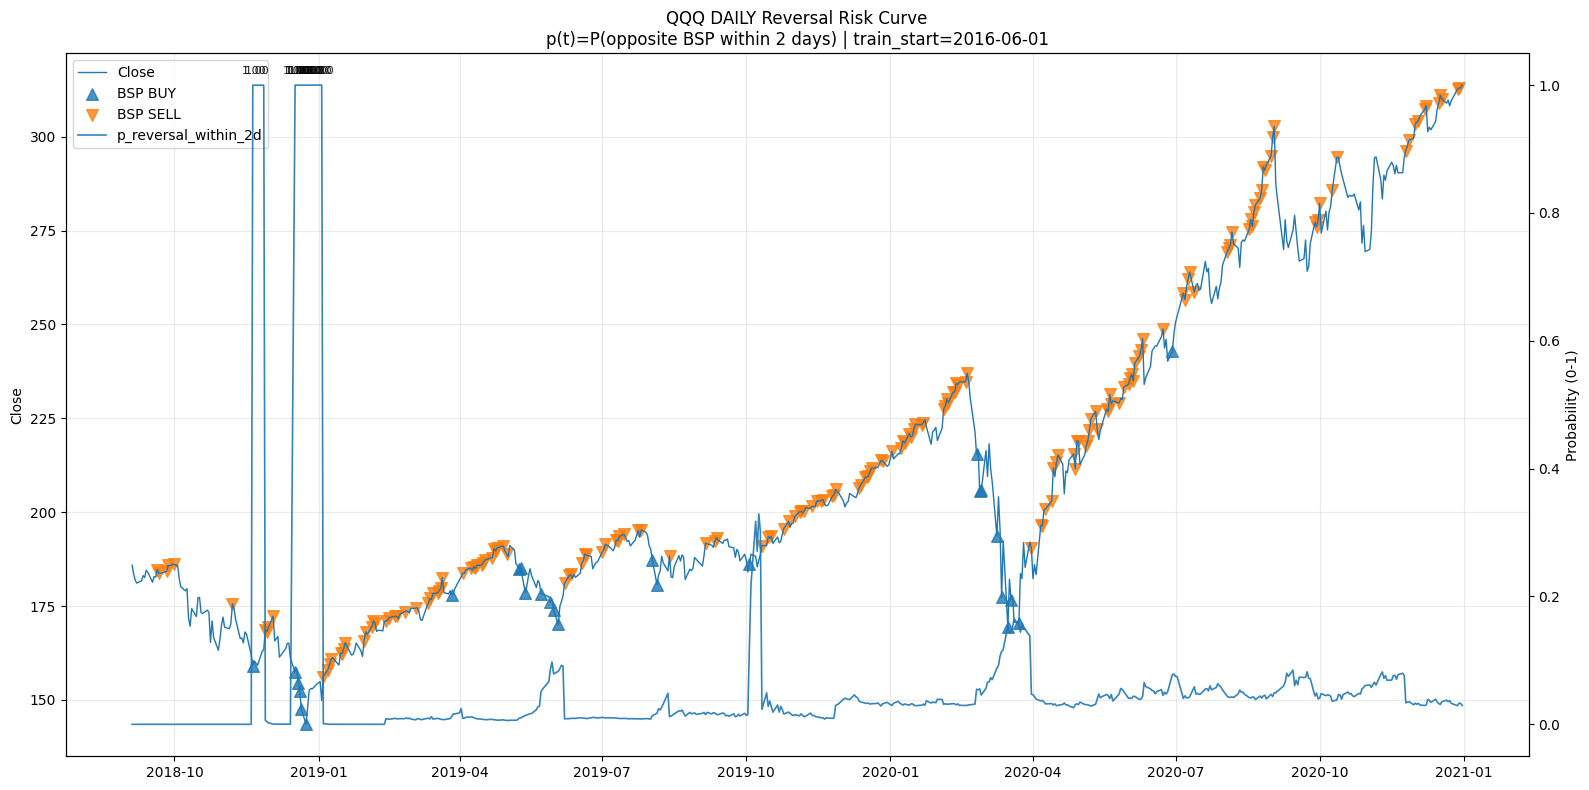

[LABELS] n=2326 pos=90 (3.87%)
[MODEL] trained=yes trained_n=2200
[BSP] total_bsp=740


,timestamp,close,p_reversal_within_2d
0,2016-06-01,110.35,NaN
1,2016-06-02,110.58,NaN
2,2016-06-03,110.06,NaN
3,2016-06-06,110.46,NaN
4,2016-06-07,110.18,NaN
5,2016-06-08,110.37,NaN
6,2016-06-09,110.19,NaN
7,2016-06-10,108.94,NaN
8,2016-06-13,108.03,NaN
9,2016-06-14,108.03,NaN


,timestamp,close,p_reversal_within_2d
2397,2025-12-11,625.58,0.033312
2398,2025-12-12,613.62,0.055207
2399,2025-12-15,610.54,0.063957
2400,2025-12-16,611.75,0.035397
2401,2025-12-17,600.41,0.062895
2402,2025-12-18,609.11,0.046026
2403,2025-12-19,617.05,0.036706
2404,2025-12-22,619.21,0.047166
2405,2025-12-23,622.11,0.034561
2406,2025-12-24,623.93,0.025322


In [1]:
# ============================================================
# DAILY Kline Reversal Risk Curve (Jupyter SINGLE CELL)
#
# Goal (your request):
#   - Use KLINES as the main data: output a probability for EACH day:
#       p(t) = P( an opposite-direction BSP occurs within next H calendar days )
#   - BSPs are used ONLY to (1) create labels, and (2) provide context features.
#
# Label rule (per day t0):
#   base_dir(t0) = direction of latest BSP at or before t0 (buy/sell)
#   y(t0)=1 if an opposite BSP occurs in (t0, t0+H] else 0
#   If no base_dir yet -> skip labeling that day (unlabeled)
#
# Walk-forward (online):
#   - Feed daily bars into Daily Chan (trigger_step=True)
#   - Collect BSPs as they appear
#   - As time advances, finalize labels for older days once horizon H is reached
#   - Retrain periodically (small-class safe calibration)
#
# Output:
#   - Plot: Close (left axis) + p_reversal_within_H (right axis)
#   - Overlay BSP buy/sell markers on price
#   - Displays the final daily_df
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Any, List, Optional
from dataclasses import dataclass

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import DATA_FIELD, KL_TYPE, AUTYPE

try:
    from Common.CEnum import DATA_SRC
except Exception:
    class DATA_SRC:
        CSV = "CSV"

from KLine.KLine_Unit import CKLine_Unit
from Common.CTime import CTime


# ----------------------------
# Chan bar builders
# ----------------------------

def to_ctime(ts) -> CTime:
    if isinstance(ts, CTime):
        return ts
    dt = pd.to_datetime(ts).to_pydatetime()
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, auto=False)
    except Exception:
        pass
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    except Exception:
        pass
    s = dt.strftime("%Y-%m-%d %H:%M:%S")
    try:
        return CTime(s, auto=False)
    except Exception:
        return CTime(s)

def build_klu(ts, o, h, l, c, v=0.0) -> CKLine_Unit:
    ct = to_ctime(ts)
    kl_dict = {
        DATA_FIELD.FIELD_TIME: ct,
        DATA_FIELD.FIELD_OPEN: float(o),
        DATA_FIELD.FIELD_HIGH: float(h),
        DATA_FIELD.FIELD_LOW:  float(l),
        DATA_FIELD.FIELD_CLOSE: float(c),
        DATA_FIELD.FIELD_VOLUME: float(v),
        "time": ct, "timestamp": ct, "datetime": ct, "dt": ct,
        "open": float(o), "high": float(h), "low": float(l), "close": float(c),
        "volume": float(v),
    }
    klu = CKLine_Unit(kl_dict)
    try:
        klu.time = ct
    except Exception:
        pass
    return klu


# ----------------------------
# CSV loader
# ----------------------------

def _pick_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = list(df.columns)
    for c in candidates:
        if c in cols:
            return c
    lower_map = {c.lower(): c for c in cols}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

def load_daily_csv(daily_csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(daily_csv_path)

    ts_col = _pick_col(df, ["timestamp", "date", "datetime", "time"])
    if ts_col is None:
        ts_col = df.columns[0]

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).reset_index(drop=True)
    df = df.rename(columns={ts_col: "timestamp"})

    open_col  = _pick_col(df, ["open", "Open", "o", "O"])
    high_col  = _pick_col(df, ["high", "High", "h", "H"])
    low_col   = _pick_col(df, ["low", "Low", "l", "L"])
    close_col = _pick_col(df, ["close", "Close", "adj_close", "Adj Close", "AdjClose", "c", "C"])
    if open_col is None or close_col is None:
        raise ValueError("Daily CSV must contain open and close columns.")
    if high_col is None:
        high_col = close_col
    if low_col is None:
        low_col = close_col

    vol_col = _pick_col(df, ["volume", "Volume", "vol", "Vol", "v", "V"])

    df["_open"]  = pd.to_numeric(df[open_col], errors="coerce").astype(float)
    df["_high"]  = pd.to_numeric(df[high_col], errors="coerce").astype(float)
    df["_low"]   = pd.to_numeric(df[low_col], errors="coerce").astype(float)
    df["_close"] = pd.to_numeric(df[close_col], errors="coerce").astype(float)
    df["_vol"]   = pd.to_numeric(df[vol_col], errors="coerce").astype(float) if vol_col is not None else 0.0

    df = df.dropna(subset=["_open", "_high", "_low", "_close"]).reset_index(drop=True)
    df["ts_norm"] = df["timestamp"].dt.normalize()
    return df


# ----------------------------
# Kline features
# ----------------------------

def _safe_div(a, b, eps=1e-12):
    return a / (b + eps)

def compute_kline_features(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy().sort_values("timestamp").reset_index(drop=True)

    o = d["_open"].astype(float)
    h = d["_high"].astype(float)
    l = d["_low"].astype(float)
    c = d["_close"].astype(float)
    v = d["_vol"].astype(float)

    prev_c = c.shift(1)
    d["ret1"] = (_safe_div(c, prev_c) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    tr = pd.concat([(h-l).abs(), (h-prev_c).abs(), (l-prev_c).abs()], axis=1).max(axis=1)
    d["tr"] = tr.fillna(0.0)
    d["atr_14"] = d["tr"].rolling(14).mean().bfill().fillna(0.0)

    d["range"] = (h - l).fillna(0.0)
    d["range_over_atr"] = _safe_div(d["range"], d["atr_14"]).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    rng = (h - l).replace(0.0, np.nan)
    d["close_pos"] = ((c - l) / rng).replace([np.inf, -np.inf], np.nan).fillna(0.5)

    d["gap"] = (_safe_div(o, prev_c) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [5, 10, 20, 40]:
        d[f"ret_{w}"] = (_safe_div(c, c.shift(w)) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        d[f"vol_{w}"] = d["ret1"].rolling(w).std().replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [20, 50, 100]:
        ma = c.rolling(w).mean()
        d[f"above_ma_{w}"] = (_safe_div(c, ma) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [5, 20, 60]:
        m = v.rolling(w).mean()
        s = v.rolling(w).std()
        d[f"vol_ratio_{w}"] = _safe_div(v, m).replace([np.inf, -np.inf], np.nan).fillna(1.0)
        d[f"vol_z_{w}"] = ((v - m) / (s + 1e-12)).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    d["vol_jump"] = _safe_div(v, v.shift(1)).replace([np.inf, -np.inf], np.nan).fillna(1.0)

    def _slope_log(x):
        x = np.asarray(x, dtype=float)
        x = np.log(np.maximum(x, 1e-12))
        t = np.arange(len(x), dtype=float)
        t = t - t.mean()
        x = x - x.mean()
        den = (t*t).sum()
        return 0.0 if den <= 0 else float((t*x).sum() / den)

    d["slope40"] = d["_close"].rolling(40).apply(_slope_log, raw=False).fillna(0.0)

    return d


KLINE_KEYS = [
    "ret1","ret_5","ret_10","ret_20","ret_40",
    "vol_5","vol_10","vol_20","vol_40",
    "atr_14","range_over_atr","close_pos","gap",
    "vol_ratio_5","vol_ratio_20","vol_ratio_60",
    "vol_z_20","vol_z_60","vol_jump",
    "above_ma_20","above_ma_50","above_ma_100",
    "slope40",
]

def make_kline_dict(kline_row: pd.Series) -> Dict[str, float]:
    d = {}
    for k in KLINE_KEYS:
        val = kline_row[k] if k in kline_row.index else 0.0
        d[f"k_{k}"] = float(val) if np.isfinite(val) else 0.0
    return d


# ----------------------------
# BSP helpers
# ----------------------------

def normalize_bsp_row(r: Dict[str, Any]) -> Dict[str, Any]:
    rr = dict(r)
    if "direction" not in rr or rr["direction"] is None:
        if rr.get("is_buy", None) is not None:
            rr["direction"] = "buy" if bool(rr["is_buy"]) else "sell"
        else:
            rr["direction"] = "buy"
    rr["direction"] = str(rr["direction"]).lower()

    if "bsp_type" in rr and rr["bsp_type"] is not None:
        rr["bsp_type"] = str(rr["bsp_type"]).lower()
    else:
        rr["bsp_type"] = "?"
    return rr

def extract_bsp_rows_from_chan(chan_obj) -> List[Dict[str, Any]]:
    if hasattr(chan_obj, "export_new_historical_bsp_to_list"):
        out = chan_obj.export_new_historical_bsp_to_list()
        return out if out else []
    return []

def latest_bsp_dir_up_to(bsp_rows: List[Dict[str, Any]], ts: pd.Timestamp) -> Optional[str]:
    past = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= ts]
    if not past:
        return None
    past = sorted(past, key=lambda x: pd.to_datetime(x["timestamp"]))
    return str(past[-1].get("direction", "")).lower()

def will_opposite_bsp_occur(bsp_rows: List[Dict[str, Any]], t0: pd.Timestamp, base_dir: str, t1: pd.Timestamp) -> int:
    opp = "sell" if base_dir == "buy" else "buy"
    for r in bsp_rows:
        tr = pd.to_datetime(r["timestamp"])
        if t0 < tr <= t1 and str(r.get("direction", "")).lower() == opp:
            return 1
    return 0

def make_daily_bsp_context(bsp_hist: List[Dict[str, Any]], cur_ts: pd.Timestamp, window_days: int = 60) -> Dict[str, float]:
    past = [r for r in bsp_hist if pd.to_datetime(r["timestamp"]) <= cur_ts]
    past = sorted(past, key=lambda x: pd.to_datetime(x["timestamp"]))
    if not past:
        return {
            "ctx_has_bsp": 0.0,
            "ctx_last_dir_buy": 0.0,
            "ctx_last_dir_sell": 0.0,
            "ctx_days_since_last_bsp": 999.0,
            "ctx_days_since_last_buy": 999.0,
            "ctx_days_since_last_sell": 999.0,
            "ctx_density_total": 0.0,
            "ctx_density_buy": 0.0,
            "ctx_density_sell": 0.0,
            "ctx_density_imb": 0.0,
        }

    last = past[-1]
    last_dir = str(last.get("direction", "")).lower()
    days_since_last = float((cur_ts.normalize() - pd.to_datetime(last["timestamp"]).normalize()).days)

    def _days_since(target: str) -> float:
        for r in reversed(past):
            if str(r.get("direction", "")).lower() == target:
                return float((cur_ts.normalize() - pd.to_datetime(r["timestamp"]).normalize()).days)
        return 999.0

    start = cur_ts.normalize() - pd.Timedelta(days=int(window_days))
    recent = [r for r in past if pd.to_datetime(r["timestamp"]).normalize() >= start]
    buy = sum(1 for r in recent if str(r.get("direction", "")).lower() == "buy")
    sell = sum(1 for r in recent if str(r.get("direction", "")).lower() == "sell")
    tot = max(1.0, float(buy + sell))

    return {
        "ctx_has_bsp": 1.0,
        "ctx_last_dir_buy": 1.0 if last_dir == "buy" else 0.0,
        "ctx_last_dir_sell": 1.0 if last_dir == "sell" else 0.0,
        "ctx_days_since_last_bsp": days_since_last,
        "ctx_days_since_last_buy": _days_since("buy"),
        "ctx_days_since_last_sell": _days_since("sell"),
        "ctx_density_total": float(len(recent)),
        "ctx_density_buy": float(buy),
        "ctx_density_sell": float(sell),
        "ctx_density_imb": float((sell - buy) / tot),
    }

def make_daily_features(kline_row: pd.Series, bsp_hist_up_to_day: List[Dict[str, Any]]) -> Dict[str, float]:
    ts = pd.to_datetime(kline_row["timestamp"])
    feats: Dict[str, float] = {}
    feats.update(make_kline_dict(kline_row))
    feats.update(make_daily_bsp_context(bsp_hist_up_to_day, ts, window_days=60))
    return feats


# ----------------------------
# Model helpers (small-class safe calibration)
# ----------------------------

def fit_dict_prob_model(X_dicts: List[Dict[str, float]], y: np.ndarray) -> Pipeline:
    vec = DictVectorizer(sparse=True)
    X = vec.fit_transform(X_dicts)

    lr = LogisticRegression(max_iter=4000, class_weight="balanced", solver="lbfgs")

    uniq, counts = np.unique(y, return_counts=True)
    if len(uniq) < 2:
        raise ValueError("Only one class in y so far; wait for more labels before training.")
    min_count = int(counts.min())

    # adaptive calibration
    if min_count >= 5:
        cal = CalibratedClassifierCV(lr, method="sigmoid", cv=3)
        cal.fit(X, y)
        return Pipeline([("vec", vec), ("model", cal)])
    elif min_count >= 3:
        cal = CalibratedClassifierCV(lr, method="sigmoid", cv=2)
        cal.fit(X, y)
        return Pipeline([("vec", vec), ("model", cal)])
    else:
        lr.fit(X, y)
        return Pipeline([("vec", vec), ("model", lr)])

def predict_dict_prob(pipe: Pipeline, X_dicts: List[Dict[str, float]]) -> np.ndarray:
    vec = pipe.named_steps["vec"]
    mdl = pipe.named_steps["model"]
    X = vec.transform(X_dicts)
    if hasattr(mdl, "predict_proba"):
        return mdl.predict_proba(X)[:, 1]
    p = mdl.decision_function(X)
    return 1.0 / (1.0 + np.exp(-p))

@dataclass
class OnlineState:
    model: Optional[Pipeline] = None
    trained_n: int = 0


# ----------------------------
# Main runner (dense daily probability)
# ----------------------------

def run_daily_reversal_risk_curve(
    daily_csv_path: str,
    code: str = "QQQ",
    daily_chan_start: str = "2016-06-01",
    plot_start: str = "2018-09-01",
    plot_end: str   = "2020-12-31",
    daily_chan_max_klines: int = 800,

    H: int = 60,  # horizon in calendar-days measured by daily bars (index + H)

    min_labeled_days_to_train: int = 400,
    retrain_every_new_labels: int = 200,

    annotate_prob_th: float = 0.90,
    annotate_max_per_year: int = 12,

    verbose: bool = True,
):
    # Load + features
    df = load_daily_csv(daily_csv_path)
    df = df[df["timestamp"] >= pd.to_datetime(daily_chan_start)].copy().reset_index(drop=True)
    if df.empty:
        raise ValueError("No daily bars after daily_chan_start. Check your CSV/date range.")
    df_feat = compute_kline_features(df)

    plot_s = pd.to_datetime(plot_start)
    plot_e = pd.to_datetime(plot_end) + pd.Timedelta(hours=23, minutes=59, seconds=59)

    # Chan config
    config = CChanConfig({
        "cal_demark": True,
        "cal_kdj": True,
        "cal_dmi": True,
        "cal_rsi": True,
        "cal_rsl": True,
        "cal_demand_index": True,
        "cal_adline": True,
        "cal_bb_vals": True,
        "cal_kc_vals": True,
        "cal_starc_vals": True,
        "bi_strict": True,
        "trigger_step": True,
        "skip_step": 0,
        "divergence_rate": float("inf"),
        "bsp2_follow_1": True,
        "bsp3_follow_1": False,
        "min_zs_cnt": 0,
        "bs1_peak": False,
        "macd_algo": "peak",
        "bs_type": "1,2,3a,1p,2s,3b",
        "print_warning": False,
        "zs_algo": "normal",
    })

    daily_chan = SlidingWindowChan(
        code=code,
        begin_time=None,
        end_time=None,
        data_src=getattr(DATA_SRC, "CSV", "CSV"),
        lv_list=[KL_TYPE.K_DAY],
        config=config,
        autype=AUTYPE.QFQ,
        max_klines=int(daily_chan_max_klines),
    )

    # BSP storage (for labels + context)
    bsp_rows: List[Dict[str, Any]] = []
    seen_bsp = set()

    # Online training data (daily)
    X_days: List[Dict[str, float]] = []
    y_days: List[int] = []
    new_labels = 0
    st = OnlineState()

    # pending days to label once horizon reached
    pending_day_idx: List[int] = []

    # output prob series
    p_series = np.full(len(df_feat), np.nan, dtype=float)

    def maybe_train():
        nonlocal new_labels
        if len(y_days) < int(min_labeled_days_to_train):
            return
        if st.model is None or new_labels >= int(retrain_every_new_labels):
            y = np.asarray(y_days, dtype=int)
            if len(np.unique(y)) < 2:
                return
            try:
                st.model = fit_dict_prob_model(X_days, y)
                st.trained_n = len(y)
                if verbose:
                    print(f"[TRAIN][DAILY] n={len(y)} pos={int(y.sum())} ({y.mean():.2%})")
                new_labels = 0
            except ValueError as e:
                if verbose:
                    print(f"[TRAIN][DAILY] skipped: {e}")

    # walk-forward daily
    for i in range(len(df_feat)):
        ts = pd.to_datetime(df_feat.loc[i, "timestamp"])

        # feed chan
        daily_chan.process_new_kline(build_klu(
            ts=ts,
            o=float(df_feat.loc[i, "_open"]),
            h=float(df_feat.loc[i, "_high"]),
            l=float(df_feat.loc[i, "_low"]),
            c=float(df_feat.loc[i, "_close"]),
            v=float(df_feat.loc[i, "_vol"]),
        ))

        # collect any new BSPs emitted at this step
        new_bsp = extract_bsp_rows_from_chan(daily_chan)
        if new_bsp:
            for r0 in new_bsp:
                r = normalize_bsp_row(dict(r0))
                r.setdefault("timestamp", ts)
                # de-dupe (robust-ish)
                key = (pd.to_datetime(r["timestamp"]).strftime("%Y-%m-%d"), r["direction"], r.get("bsp_type", "?"))
                if key in seen_bsp:
                    continue
                seen_bsp.add(key)
                bsp_rows.append(r)

        # add day to pending label queue
        pending_day_idx.append(i)

        # finalize labels for days j once i >= j + H
        while pending_day_idx and i >= pending_day_idx[0] + int(H):
            j = pending_day_idx.pop(0)
            t0 = pd.to_datetime(df_feat.loc[j, "timestamp"])
            t1 = pd.to_datetime(df_feat.loc[j + int(H), "timestamp"])

            # base_dir defined by latest BSP up to t0
            base_dir = latest_bsp_dir_up_to(bsp_rows, t0)
            if base_dir not in ("buy", "sell"):
                continue

            y = will_opposite_bsp_occur(bsp_rows, t0, base_dir, t1)

            # features must use BSP history up to day j (no future leakage)
            bsp_hist_up_to_j = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= t0]
            feat_j = make_daily_features(df_feat.loc[j], bsp_hist_up_to_j)

            X_days.append(feat_j)
            y_days.append(int(y))
            new_labels += 1

        # train if ready
        maybe_train()

        # predict today's p (using BSP history up to today)
        if st.model is not None:
            bsp_hist_up_to_i = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= ts]
            feat_i = make_daily_features(df_feat.loc[i], bsp_hist_up_to_i)
            p_series[i] = float(predict_dict_prob(st.model, [feat_i])[0])

    # build outputs
    daily_df = pd.DataFrame({
        "timestamp": pd.to_datetime(df_feat["timestamp"]),
        "close": df_feat["_close"].astype(float).to_numpy(),
        f"p_reversal_within_{H}d": p_series,
    })

    bsp_df = pd.DataFrame(bsp_rows) if len(bsp_rows) else pd.DataFrame(columns=["timestamp","direction","bsp_type"])
    if not bsp_df.empty:
        bsp_df["timestamp"] = pd.to_datetime(bsp_df["timestamp"], errors="coerce")
        bsp_df = bsp_df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    # plot range filter
    m = (daily_df["timestamp"] >= plot_s) & (daily_df["timestamp"] <= plot_e)
    daily_plot = daily_df.loc[m].copy()

    # plot
    plt.figure(figsize=(16, 8))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.plot(daily_plot["timestamp"], daily_plot["close"], linewidth=1.0, label="Close")

    pcol = f"p_reversal_within_{H}d"
    ax2.plot(daily_plot["timestamp"], daily_plot[pcol], linewidth=1.2, alpha=0.9, label=pcol)

    # overlay BSP markers on price (only within plot window)
    if not bsp_df.empty:
        bsp_plot = bsp_df[(bsp_df["timestamp"] >= plot_s) & (bsp_df["timestamp"] <= plot_e)].copy()
        if not bsp_plot.empty:
            close_map = df_feat.set_index("ts_norm")["_close"].to_dict()
            bsp_plot["px"] = bsp_plot["timestamp"].dt.normalize().map(close_map)
            bsp_plot = bsp_plot.dropna(subset=["px"])

            buy_mask = bsp_plot["direction"].astype(str).str.lower().eq("buy")
            sell_mask = bsp_plot["direction"].astype(str).str.lower().eq("sell")

            if buy_mask.any():
                ax1.scatter(
                    bsp_plot.loc[buy_mask, "timestamp"],
                    bsp_plot.loc[buy_mask, "px"],
                    marker="^", s=70, alpha=0.8,
                    label="BSP BUY"
                )
            if sell_mask.any():
                ax1.scatter(
                    bsp_plot.loc[sell_mask, "timestamp"],
                    bsp_plot.loc[sell_mask, "px"],
                    marker="v", s=70, alpha=0.8,
                    label="BSP SELL"
                )

    # annotate high-prob days
    ann = daily_plot[["timestamp", pcol, "close"]].copy()
    ann[pcol] = pd.to_numeric(ann[pcol], errors="coerce")
    ann = ann.dropna(subset=[pcol])
    ann = ann[ann[pcol] >= float(annotate_prob_th)]
    if not ann.empty:
        ann["year"] = ann["timestamp"].dt.year
        ann = ann.sort_values(["year", pcol], ascending=[True, False]).groupby("year").head(int(annotate_max_per_year))
        for _, r in ann.iterrows():
            ax2.annotate(
                f"{float(r[pcol]):.2f}",
                (r["timestamp"], float(r[pcol])),
                textcoords="offset points",
                xytext=(0, 8),
                ha="center",
                fontsize=8,
                alpha=0.9,
            )

    ax1.set_title(
        f"{code} DAILY Reversal Risk Curve\n"
        f"p(t)=P(opposite BSP within {H} days) | train_start={daily_chan_start}"
    )
    ax1.set_ylabel("Close")
    ax2.set_ylabel(f"Probability (0-1)")

    # combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    ax1.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    if verbose:
        y = np.asarray(y_days, dtype=int) if len(y_days) else np.array([], dtype=int)
        if len(y):
            print(f"[LABELS] n={len(y)} pos={int(y.sum())} ({y.mean():.2%})")
        print(f"[MODEL] trained={'yes' if st.model is not None else 'no'} trained_n={st.trained_n}")
        print(f"[BSP] total_bsp={len(bsp_df)}")

    return daily_df, bsp_df


# ============================================================
# RUN
# ============================================================

daily_df, bsp_df = run_daily_reversal_risk_curve(
    daily_csv_path="DataAPI/data/QQQ_DAY.csv",
    code="QQQ",
    daily_chan_start="2016-06-01",
    plot_start="2018-09-01",
    plot_end="2020-12-31",
    daily_chan_max_klines=800,

    H=2,

    min_labeled_days_to_train=400,
    retrain_every_new_labels=200,

    annotate_prob_th=0.90,
    annotate_max_per_year=12,

    verbose=True,
)

display(daily_df.head(10))
display(daily_df.tail(10))


[TRAIN][DAILY] n=400 pos=69 (17.25%)
[TRAIN][DAILY] n=410 pos=69 (16.83%)
[TRAIN][DAILY] n=420 pos=70 (16.67%)
[TRAIN][DAILY] n=430 pos=70 (16.28%)
[TRAIN][DAILY] n=440 pos=72 (16.36%)
[TRAIN][DAILY] n=450 pos=75 (16.67%)
[TRAIN][DAILY] n=460 pos=75 (16.30%)
[TRAIN][DAILY] n=470 pos=77 (16.38%)
[TRAIN][DAILY] n=480 pos=80 (16.67%)
[TRAIN][DAILY] n=490 pos=82 (16.73%)
[TRAIN][DAILY] n=500 pos=84 (16.80%)
[TRAIN][DAILY] n=510 pos=85 (16.67%)
[TRAIN][DAILY] n=520 pos=91 (17.50%)
[TRAIN][DAILY] n=530 pos=97 (18.30%)
[TRAIN][DAILY] n=540 pos=101 (18.70%)
[TRAIN][DAILY] n=550 pos=110 (20.00%)
[TRAIN][DAILY] n=560 pos=113 (20.18%)
[TRAIN][DAILY] n=570 pos=118 (20.70%)
[TRAIN][DAILY] n=580 pos=119 (20.52%)
[TRAIN][DAILY] n=590 pos=120 (20.34%)
[TRAIN][DAILY] n=600 pos=120 (20.00%)
[TRAIN][DAILY] n=610 pos=120 (19.67%)
[TRAIN][DAILY] n=620 pos=121 (19.52%)
[TRAIN][DAILY] n=630 pos=123 (19.52%)
[TRAIN][DAILY] n=640 pos=128 (20.00%)
[TRAIN][DAILY] n=650 pos=128 (19.69%)
[TRAIN][DAILY] n=660 pos=1

c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1120 pos=214 (19.11%)
[TRAIN][DAILY] n=1130 pos=216 (19.12%)
[TRAIN][DAILY] n=1140 pos=217 (19.04%)
[TRAIN][DAILY] n=1150 pos=218 (18.96%)
[TRAIN][DAILY] n=1160 pos=221 (19.05%)
[TRAIN][DAILY] n=1170 pos=223 (19.06%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1180 pos=223 (18.90%)
[TRAIN][DAILY] n=1190 pos=223 (18.74%)
[TRAIN][DAILY] n=1200 pos=223 (18.58%)
[TRAIN][DAILY] n=1210 pos=224 (18.51%)
[TRAIN][DAILY] n=1220 pos=226 (18.52%)
[TRAIN][DAILY] n=1230 pos=228 (18.54%)
[TRAIN][DAILY] n=1240 pos=229 (18.47%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1250 pos=231 (18.48%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1260 pos=236 (18.73%)
[TRAIN][DAILY] n=1270 pos=240 (18.90%)
[TRAIN][DAILY] n=1280 pos=240 (18.75%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1290 pos=240 (18.60%)
[TRAIN][DAILY] n=1300 pos=243 (18.69%)
[TRAIN][DAILY] n=1310 pos=246 (18.78%)
[TRAIN][DAILY] n=1320 pos=248 (18.79%)
[TRAIN][DAILY] n=1330 pos=250 (18.80%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1340 pos=253 (18.88%)
[TRAIN][DAILY] n=1350 pos=256 (18.96%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1360 pos=256 (18.82%)
[TRAIN][DAILY] n=1370 pos=257 (18.76%)
[TRAIN][DAILY] n=1380 pos=260 (18.84%)
[TRAIN][DAILY] n=1390 pos=267 (19.21%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1400 pos=267 (19.07%)
[TRAIN][DAILY] n=1410 pos=267 (18.94%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1420 pos=268 (18.87%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1430 pos=271 (18.95%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1440 pos=275 (19.10%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1450 pos=278 (19.17%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1460 pos=280 (19.18%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1470 pos=284 (19.32%)
[TRAIN][DAILY] n=1480 pos=284 (19.19%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1490 pos=288 (19.33%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1500 pos=293 (19.53%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1510 pos=298 (19.74%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1520 pos=299 (19.67%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1530 pos=302 (19.74%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1540 pos=304 (19.74%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1550 pos=309 (19.94%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1560 pos=310 (19.87%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1570 pos=311 (19.81%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1580 pos=312 (19.75%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1590 pos=314 (19.75%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1600 pos=314 (19.62%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1610 pos=318 (19.75%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1620 pos=323 (19.94%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1630 pos=326 (20.00%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1640 pos=329 (20.06%)
[TRAIN][DAILY] n=1650 pos=330 (20.00%)
[TRAIN][DAILY] n=1660 pos=332 (20.00%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1670 pos=332 (19.88%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1680 pos=332 (19.76%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1690 pos=332 (19.64%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1700 pos=334 (19.65%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1710 pos=334 (19.53%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1720 pos=335 (19.48%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1730 pos=340 (19.65%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1740 pos=343 (19.71%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1750 pos=346 (19.77%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1760 pos=350 (19.89%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1770 pos=353 (19.94%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1780 pos=358 (20.11%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1790 pos=363 (20.28%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1800 pos=363 (20.17%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1810 pos=364 (20.11%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1820 pos=364 (20.00%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1830 pos=366 (20.00%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1840 pos=369 (20.05%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1850 pos=372 (20.11%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1860 pos=373 (20.05%)
[TRAIN][DAILY] n=1870 pos=373 (19.95%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1880 pos=375 (19.95%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1890 pos=376 (19.89%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1900 pos=379 (19.95%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1910 pos=383 (20.05%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1920 pos=383 (19.95%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1930 pos=384 (19.90%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1940 pos=385 (19.85%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1950 pos=387 (19.85%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=1960 pos=387 (19.74%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1970 pos=391 (19.85%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1980 pos=392 (19.80%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=1990 pos=396 (19.90%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=2000 pos=402 (20.10%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=2010 pos=402 (20.00%)
[TRAIN][DAILY] n=2020 pos=405 (20.05%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=2030 pos=407 (20.05%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=2040 pos=408 (20.00%)
[TRAIN][DAILY] n=2050 pos=410 (20.00%)
[TRAIN][DAILY] n=2060 pos=411 (19.95%)
[TRAIN][DAILY] n=2070 pos=411 (19.86%)
[TRAIN][DAILY] n=2080 pos=415 (19.95%)
[TRAIN][DAILY] n=2090 pos=417 (19.95%)
[TRAIN][DAILY] n=2100 pos=419 (19.95%)
[TRAIN][DAILY] n=2110 pos=419 (19.86%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=2120 pos=425 (20.05%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    htt

[TRAIN][DAILY] n=2130 pos=430 (20.19%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=2140 pos=433 (20.23%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=2150 pos=438 (20.37%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=2160 pos=442 (20.46%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=2170 pos=442 (20.37%)
[TRAIN][DAILY] n=2180 pos=442 (20.28%)


c:\Users\TonyTang\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 4000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[TRAIN][DAILY] n=2190 pos=442 (20.18%)
[TRAIN][DAILY] n=2200 pos=444 (20.18%)
[TRAIN][DAILY] n=2210 pos=444 (20.09%)
[TRAIN][DAILY] n=2220 pos=444 (20.00%)
[TRAIN][DAILY] n=2230 pos=445 (19.96%)
[TRAIN][DAILY] n=2240 pos=450 (20.09%)
[TRAIN][DAILY] n=2250 pos=455 (20.22%)
[TRAIN][DAILY] n=2260 pos=457 (20.22%)
[TRAIN][DAILY] n=2270 pos=459 (20.22%)
[TRAIN][DAILY] n=2280 pos=460 (20.18%)
[TRAIN][DAILY] n=2290 pos=461 (20.13%)
[TRAIN][DAILY] n=2300 pos=466 (20.26%)
[TRAIN][DAILY] n=2310 pos=470 (20.35%)
[TRAIN][DAILY] n=2320 pos=473 (20.39%)


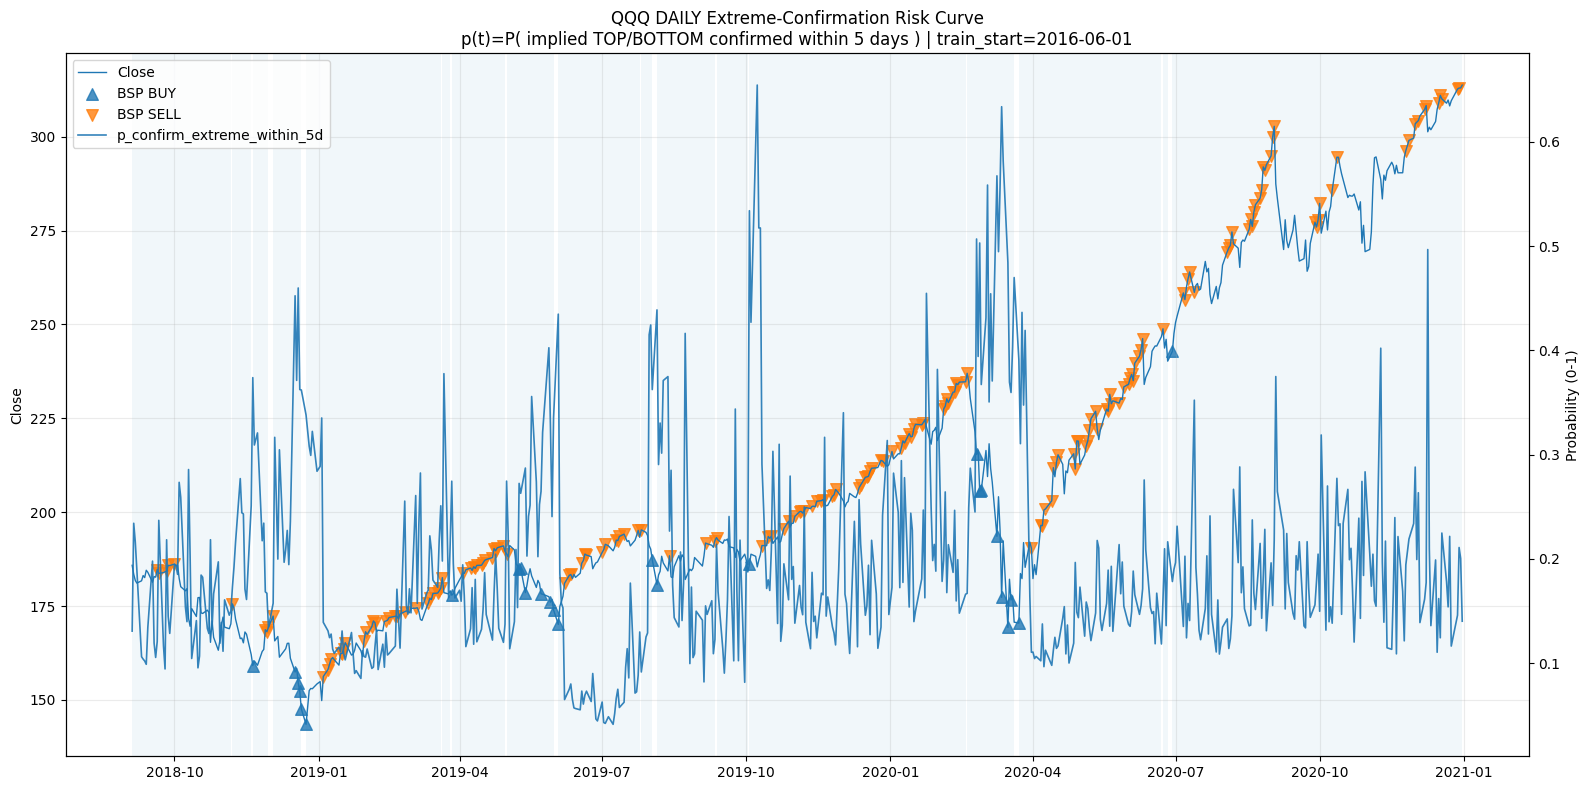

[LABELS] n=2323 pos=473 (20.36%)
[MODEL] trained=yes trained_n=2320
[BSP] total_bsp=740


,timestamp,open,high,low,close,p_confirm_extreme_within_5d,regime_chain
0,2016-06-01,110.00,110.60,109.91,110.35,NaN,unknown
1,2016-06-02,110.13,110.59,109.53,110.58,NaN,unknown
2,2016-06-03,110.37,110.42,109.34,110.06,NaN,unknown
3,2016-06-06,110.26,110.75,110.07,110.46,NaN,unknown
4,2016-06-07,110.52,110.63,110.13,110.18,NaN,unknown
5,2016-06-08,110.37,110.60,109.96,110.37,NaN,unknown
6,2016-06-09,109.92,110.31,109.71,110.19,NaN,unknown
7,2016-06-10,109.19,109.40,108.56,108.94,NaN,unknown
8,2016-06-13,108.32,108.93,107.89,108.03,NaN,unknown
9,2016-06-14,107.74,108.42,107.24,108.03,NaN,unknown


,timestamp,open,high,low,close,p_confirm_extreme_within_5d,regime_chain
2397,2025-12-11,623.82,625.78,617.7200,625.58,0.186982,up
2398,2025-12-12,622.08,623.54,611.3600,613.62,0.400535,up
2399,2025-12-15,618.37,618.42,609.3200,610.54,0.296692,up
2400,2025-12-16,608.26,613.51,606.9101,611.75,0.171043,up
2401,2025-12-17,613.06,613.65,600.2800,600.41,0.420024,up
2402,2025-12-18,609.80,612.93,606.9200,609.11,0.221258,up
2403,2025-12-19,611.95,617.62,611.8700,617.05,0.145472,up
2404,2025-12-22,621.35,621.65,617.7700,619.21,0.166829,up
2405,2025-12-23,618.20,622.41,617.7800,622.11,0.121314,up
2406,2025-12-24,621.99,624.28,621.7200,623.93,0.108003,up


In [4]:
# ============================================================
# DAILY Kline "Extreme Confirmation" Risk Curve (Jupyter SINGLE CELL)
#
# NEW Goal (your request):
#   - Output a probability for EACH day:
#       p(t) = P( today's implied extreme is CONFIRMED within next N days )
#
# Label rule (per day t0):
#   base_dir(t0) = direction of latest BSP at or before t0 (buy/sell)
#   If base_dir == 'sell' (candidate TOP day):
#       y(t0)=1 if max(high in next N days) < high(t0) else 0
#   If base_dir == 'buy'  (candidate BOTTOM day):
#       y(t0)=1 if min(low  in next N days) > low(t0)  else 0
#   If no base_dir yet -> skip labeling that day (unlabeled)
#
# Trend regime (per your chain rule):
#   - Uptrend:   start = end of a BUY chain, end = end of next SELL chain
#   - Downtrend: start = end of a SELL chain, end = end of next BUY chain
#
# Walk-forward (online):
#   - Feed daily bars into Daily Chan (trigger_step=True)
#   - Collect BSPs as they appear
#   - As time advances, finalize labels for older days once horizon N is reached
#   - Retrain periodically (small-class safe calibration)
#
# Output:
#   - Plot: Close (left axis) + p_confirm_extreme_within_Nd (right axis)
#   - Overlay BSP buy/sell markers on price
#   - Optional shading by chain-regime (up/down)
#   - Displays the final daily_df
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Any, List, Optional
from dataclasses import dataclass

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import DATA_FIELD, KL_TYPE, AUTYPE

try:
    from Common.CEnum import DATA_SRC
except Exception:
    class DATA_SRC:
        CSV = "CSV"

from KLine.KLine_Unit import CKLine_Unit
from Common.CTime import CTime

try:
    from IPython.display import display
except Exception:
    def display(x):
        print(x)


# ----------------------------
# Chan bar builders
# ----------------------------

def to_ctime(ts) -> CTime:
    if isinstance(ts, CTime):
        return ts
    dt = pd.to_datetime(ts).to_pydatetime()
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, auto=False)
    except Exception:
        pass
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    except Exception:
        pass
    s = dt.strftime("%Y-%m-%d %H:%M:%S")
    try:
        return CTime(s, auto=False)
    except Exception:
        return CTime(s)

def build_klu(ts, o, h, l, c, v=0.0) -> CKLine_Unit:
    ct = to_ctime(ts)
    kl_dict = {
        DATA_FIELD.FIELD_TIME: ct,
        DATA_FIELD.FIELD_OPEN: float(o),
        DATA_FIELD.FIELD_HIGH: float(h),
        DATA_FIELD.FIELD_LOW:  float(l),
        DATA_FIELD.FIELD_CLOSE: float(c),
        DATA_FIELD.FIELD_VOLUME: float(v),
        "time": ct, "timestamp": ct, "datetime": ct, "dt": ct,
        "open": float(o), "high": float(h), "low": float(l), "close": float(c),
        "volume": float(v),
    }
    klu = CKLine_Unit(kl_dict)
    try:
        klu.time = ct
    except Exception:
        pass
    return klu


# ----------------------------
# CSV loader
# ----------------------------

def _pick_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = list(df.columns)
    for c in candidates:
        if c in cols:
            return c
    lower_map = {c.lower(): c for c in cols}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

def load_daily_csv(daily_csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(daily_csv_path)

    ts_col = _pick_col(df, ["timestamp", "date", "datetime", "time"])
    if ts_col is None:
        ts_col = df.columns[0]

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).reset_index(drop=True)
    df = df.rename(columns={ts_col: "timestamp"})

    open_col  = _pick_col(df, ["open", "Open", "o", "O"])
    high_col  = _pick_col(df, ["high", "High", "h", "H"])
    low_col   = _pick_col(df, ["low", "Low", "l", "L"])
    close_col = _pick_col(df, ["close", "Close", "adj_close", "Adj Close", "AdjClose", "c", "C"])
    if open_col is None or close_col is None:
        raise ValueError("Daily CSV must contain open and close columns.")
    if high_col is None:
        high_col = close_col
    if low_col is None:
        low_col = close_col

    vol_col = _pick_col(df, ["volume", "Volume", "vol", "Vol", "v", "V"])

    df["_open"]  = pd.to_numeric(df[open_col], errors="coerce").astype(float)
    df["_high"]  = pd.to_numeric(df[high_col], errors="coerce").astype(float)
    df["_low"]   = pd.to_numeric(df[low_col], errors="coerce").astype(float)
    df["_close"] = pd.to_numeric(df[close_col], errors="coerce").astype(float)
    df["_vol"]   = pd.to_numeric(df[vol_col], errors="coerce").astype(float) if vol_col is not None else 0.0

    df = df.dropna(subset=["_open", "_high", "_low", "_close"]).reset_index(drop=True)
    df["ts_norm"] = df["timestamp"].dt.normalize()
    return df


# ----------------------------
# Kline features
# ----------------------------

def _safe_div(a, b, eps=1e-12):
    return a / (b + eps)

def compute_kline_features(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy().sort_values("timestamp").reset_index(drop=True)

    o = d["_open"].astype(float)
    h = d["_high"].astype(float)
    l = d["_low"].astype(float)
    c = d["_close"].astype(float)
    v = d["_vol"].astype(float)

    prev_c = c.shift(1)
    d["ret1"] = (_safe_div(c, prev_c) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    tr = pd.concat([(h-l).abs(), (h-prev_c).abs(), (l-prev_c).abs()], axis=1).max(axis=1)
    d["tr"] = tr.fillna(0.0)
    d["atr_14"] = d["tr"].rolling(14).mean().bfill().fillna(0.0)

    d["range"] = (h - l).fillna(0.0)
    d["range_over_atr"] = _safe_div(d["range"], d["atr_14"]).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    rng = (h - l).replace(0.0, np.nan)
    d["close_pos"] = ((c - l) / rng).replace([np.inf, -np.inf], np.nan).fillna(0.5)

    d["gap"] = (_safe_div(o, prev_c) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [5, 10, 20, 40]:
        d[f"ret_{w}"] = (_safe_div(c, c.shift(w)) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        d[f"vol_{w}"] = d["ret1"].rolling(w).std().replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [20, 50, 100]:
        ma = c.rolling(w).mean()
        d[f"above_ma_{w}"] = (_safe_div(c, ma) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [5, 20, 60]:
        m = v.rolling(w).mean()
        s = v.rolling(w).std()
        d[f"vol_ratio_{w}"] = _safe_div(v, m).replace([np.inf, -np.inf], np.nan).fillna(1.0)
        d[f"vol_z_{w}"] = ((v - m) / (s + 1e-12)).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    d["vol_jump"] = _safe_div(v, v.shift(1)).replace([np.inf, -np.inf], np.nan).fillna(1.0)

    def _slope_log(x):
        x = np.asarray(x, dtype=float)
        x = np.log(np.maximum(x, 1e-12))
        t = np.arange(len(x), dtype=float)
        t = t - t.mean()
        x = x - x.mean()
        den = (t*t).sum()
        return 0.0 if den <= 0 else float((t*x).sum() / den)

    d["slope40"] = d["_close"].rolling(40).apply(_slope_log, raw=False).fillna(0.0)

    return d


KLINE_KEYS = [
    "ret1","ret_5","ret_10","ret_20","ret_40",
    "vol_5","vol_10","vol_20","vol_40",
    "atr_14","range_over_atr","close_pos","gap",
    "vol_ratio_5","vol_ratio_20","vol_ratio_60",
    "vol_z_20","vol_z_60","vol_jump",
    "above_ma_20","above_ma_50","above_ma_100",
    "slope40",
]

def make_kline_dict(kline_row: pd.Series) -> Dict[str, float]:
    d = {}
    for k in KLINE_KEYS:
        val = kline_row[k] if k in kline_row.index else 0.0
        d[f"k_{k}"] = float(val) if np.isfinite(val) else 0.0
    return d


# ----------------------------
# BSP helpers
# ----------------------------

def normalize_bsp_row(r: Dict[str, Any]) -> Dict[str, Any]:
    rr = dict(r)
    if "direction" not in rr or rr["direction"] is None:
        if rr.get("is_buy", None) is not None:
            rr["direction"] = "buy" if bool(rr["is_buy"]) else "sell"
        else:
            rr["direction"] = "buy"
    rr["direction"] = str(rr["direction"]).lower()

    if "bsp_type" in rr and rr["bsp_type"] is not None:
        rr["bsp_type"] = str(rr["bsp_type"]).lower()
    else:
        rr["bsp_type"] = "?"
    return rr

def extract_bsp_rows_from_chan(chan_obj) -> List[Dict[str, Any]]:
    # keep your original method name, but tolerate alternative exports
    if hasattr(chan_obj, "export_new_historical_bsp_to_list"):
        out = chan_obj.export_new_historical_bsp_to_list()
        return out if out else []
    if hasattr(chan_obj, "export_new_bsp_to_list"):
        out = chan_obj.export_new_bsp_to_list()
        return out if out else []
    return []

def latest_bsp_dir_up_to(bsp_rows: List[Dict[str, Any]], ts: pd.Timestamp) -> Optional[str]:
    past = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= ts]
    if not past:
        return None
    past = sorted(past, key=lambda x: pd.to_datetime(x["timestamp"]))
    return str(past[-1].get("direction", "")).lower()


# ----------------------------
# BSP context features
# ----------------------------

def make_daily_bsp_context(bsp_hist: List[Dict[str, Any]], cur_ts: pd.Timestamp, window_days: int = 60) -> Dict[str, float]:
    past = [r for r in bsp_hist if pd.to_datetime(r["timestamp"]) <= cur_ts]
    past = sorted(past, key=lambda x: pd.to_datetime(x["timestamp"]))
    if not past:
        return {
            "ctx_has_bsp": 0.0,
            "ctx_last_dir_buy": 0.0,
            "ctx_last_dir_sell": 0.0,
            "ctx_days_since_last_bsp": 999.0,
            "ctx_days_since_last_buy": 999.0,
            "ctx_days_since_last_sell": 999.0,
            "ctx_density_total": 0.0,
            "ctx_density_buy": 0.0,
            "ctx_density_sell": 0.0,
            "ctx_density_imb": 0.0,
        }

    last = past[-1]
    last_dir = str(last.get("direction", "")).lower()
    days_since_last = float((cur_ts.normalize() - pd.to_datetime(last["timestamp"]).normalize()).days)

    def _days_since(target: str) -> float:
        for r in reversed(past):
            if str(r.get("direction", "")).lower() == target:
                return float((cur_ts.normalize() - pd.to_datetime(r["timestamp"]).normalize()).days)
        return 999.0

    start = cur_ts.normalize() - pd.Timedelta(days=int(window_days))
    recent = [r for r in past if pd.to_datetime(r["timestamp"]).normalize() >= start]
    buy = sum(1 for r in recent if str(r.get("direction", "")).lower() == "buy")
    sell = sum(1 for r in recent if str(r.get("direction", "")).lower() == "sell")
    tot = max(1.0, float(buy + sell))

    return {
        "ctx_has_bsp": 1.0,
        "ctx_last_dir_buy": 1.0 if last_dir == "buy" else 0.0,
        "ctx_last_dir_sell": 1.0 if last_dir == "sell" else 0.0,
        "ctx_days_since_last_bsp": days_since_last,
        "ctx_days_since_last_buy": _days_since("buy"),
        "ctx_days_since_last_sell": _days_since("sell"),
        "ctx_density_total": float(len(recent)),
        "ctx_density_buy": float(buy),
        "ctx_density_sell": float(sell),
        "ctx_density_imb": float((sell - buy) / tot),
    }

def make_daily_features(kline_row: pd.Series, bsp_hist_up_to_day: List[Dict[str, Any]]) -> Dict[str, float]:
    ts = pd.to_datetime(kline_row["timestamp"])
    feats: Dict[str, float] = {}
    feats.update(make_kline_dict(kline_row))
    feats.update(make_daily_bsp_context(bsp_hist_up_to_day, ts, window_days=60))
    return feats


# ----------------------------
# NEW LABEL: "extreme confirmed within N days"
# ----------------------------

def label_top_bottom_for_day(
    df_feat: pd.DataFrame,
    day_idx: int,
    N: int,
    base_dir: str,
) -> Optional[int]:
    """
    base_dir is the latest BSP direction at/before this day:
      - if base_dir == 'sell': candidate TOP day, y=1 if next N days highs never exceed today's high
      - if base_dir == 'buy' : candidate BOTTOM day, y=1 if next N days lows never go below today's low
    Returns 0/1, or None if not enough future bars.
    """
    if N <= 0:
        return None
    if day_idx + N >= len(df_feat):
        return None  # not enough future days to finalize

    h0 = float(df_feat.loc[day_idx, "_high"])
    l0 = float(df_feat.loc[day_idx, "_low"])

    fut = df_feat.loc[day_idx+1:day_idx+N]
    if fut.empty:
        return None

    if base_dir == "sell":
        mx = float(fut["_high"].max())
        return 1 if mx < h0 else 0

    if base_dir == "buy":
        mn = float(fut["_low"].min())
        return 1 if mn > l0 else 0

    return None


# ----------------------------
# Chain-regime logic (per your rule)
# ----------------------------

def compute_chain_endpoints(bsp_rows: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Consecutive same-direction BSPs form a chain.
    Endpoint = last BSP before direction flips.
    Returns list: {end_ts (normalized), end_dir, end_i}
    """
    if not bsp_rows:
        return []
    bsps = sorted(bsp_rows, key=lambda r: pd.to_datetime(r["timestamp"]))
    ends = []

    cur_dir = str(bsps[0].get("direction", "")).lower()
    cur_end = bsps[0]
    cur_end_i = 0

    for i in range(1, len(bsps)):
        d = str(bsps[i].get("direction", "")).lower()
        if d == cur_dir:
            cur_end = bsps[i]
            cur_end_i = i
        else:
            ends.append({
                "end_ts": pd.to_datetime(cur_end["timestamp"]).normalize(),
                "end_dir": cur_dir,
                "end_i": cur_end_i,
            })
            cur_dir = d
            cur_end = bsps[i]
            cur_end_i = i

    ends.append({
        "end_ts": pd.to_datetime(cur_end["timestamp"]).normalize(),
        "end_dir": cur_dir,
        "end_i": cur_end_i,
    })
    return ends

def build_trend_regime_by_chains(
    daily_df: pd.DataFrame,
    bsp_rows: List[Dict[str, Any]],
) -> pd.Series:
    """
    Your regime rule:
      - Uptrend: from end of BUY chain -> end of next SELL chain
      - Downtrend: from end of SELL chain -> end of next BUY chain
    Output per-day regime in {'up','down','unknown'}.
    """
    if daily_df.empty:
        return pd.Series([], dtype=str)

    idx = pd.to_datetime(daily_df["timestamp"]).dt.normalize()
    regime = pd.Series("unknown", index=idx)

    ends = compute_chain_endpoints(bsp_rows)
    if len(ends) < 2:
        return regime.reindex(idx).fillna("unknown")

    for k in range(len(ends) - 1):
        a = ends[k]
        b = ends[k+1]
        a_ts, a_dir = a["end_ts"], a["end_dir"]
        b_ts, b_dir = b["end_ts"], b["end_dir"]

        if a_dir == "buy" and b_dir == "sell":
            m = (regime.index >= a_ts) & (regime.index <= b_ts)
            regime.loc[m] = "up"

        if a_dir == "sell" and b_dir == "buy":
            m = (regime.index >= a_ts) & (regime.index <= b_ts)
            regime.loc[m] = "down"

    return regime.reindex(idx).fillna("unknown")


# ----------------------------
# Model helpers (small-class safe calibration)
# ----------------------------

def fit_dict_prob_model(X_dicts: List[Dict[str, float]], y: np.ndarray) -> Pipeline:
    vec = DictVectorizer(sparse=True)
    X = vec.fit_transform(X_dicts)

    lr = LogisticRegression(max_iter=4000, class_weight="balanced", solver="lbfgs")

    uniq, counts = np.unique(y, return_counts=True)
    if len(uniq) < 2:
        raise ValueError("Only one class in y so far; wait for more labels before training.")
    min_count = int(counts.min())

    if min_count >= 5:
        cal = CalibratedClassifierCV(lr, method="sigmoid", cv=3)
        cal.fit(X, y)
        return Pipeline([("vec", vec), ("model", cal)])
    elif min_count >= 3:
        cal = CalibratedClassifierCV(lr, method="sigmoid", cv=2)
        cal.fit(X, y)
        return Pipeline([("vec", vec), ("model", cal)])
    else:
        lr.fit(X, y)
        return Pipeline([("vec", vec), ("model", lr)])

def predict_dict_prob(pipe: Pipeline, X_dicts: List[Dict[str, float]]) -> np.ndarray:
    vec = pipe.named_steps["vec"]
    mdl = pipe.named_steps["model"]
    X = vec.transform(X_dicts)
    if hasattr(mdl, "predict_proba"):
        return mdl.predict_proba(X)[:, 1]
    p = mdl.decision_function(X)
    return 1.0 / (1.0 + np.exp(-p))

@dataclass
class OnlineState:
    model: Optional[Pipeline] = None
    trained_n: int = 0


# ----------------------------
# Main runner (dense daily probability)
# ----------------------------

def run_daily_extreme_confirm_curve(
    daily_csv_path: str,
    code: str = "QQQ",
    daily_chan_start: str = "2016-06-01",
    plot_start: str = "2018-09-01",
    plot_end: str   = "2020-12-31",
    daily_chan_max_klines: int = 800,

    N: int = 60,  # horizon in days for "no-break" confirmation

    min_labeled_days_to_train: int = 400,
    retrain_every_new_labels: int = 200,

    annotate_prob_th: float = 0.90,
    annotate_max_per_year: int = 12,

    shade_regimes: bool = True,
    verbose: bool = True,
):
    # Load + features
    df = load_daily_csv(daily_csv_path)
    df = df[df["timestamp"] >= pd.to_datetime(daily_chan_start)].copy().reset_index(drop=True)
    if df.empty:
        raise ValueError("No daily bars after daily_chan_start. Check your CSV/date range.")
    df_feat = compute_kline_features(df)

    plot_s = pd.to_datetime(plot_start)
    plot_e = pd.to_datetime(plot_end) + pd.Timedelta(hours=23, minutes=59, seconds=59)

    # Chan config
    config = CChanConfig({
        "cal_demark": True,
        "cal_kdj": True,
        "cal_dmi": True,
        "cal_rsi": True,
        "cal_rsl": True,
        "cal_demand_index": True,
        "cal_adline": True,
        "cal_bb_vals": True,
        "cal_kc_vals": True,
        "cal_starc_vals": True,
        "bi_strict": True,
        "trigger_step": True,
        "skip_step": 0,
        "divergence_rate": float("inf"),
        "bsp2_follow_1": True,
        "bsp3_follow_1": False,
        "min_zs_cnt": 0,
        "bs1_peak": False,
        "macd_algo": "peak",
        "bs_type": "1,2,3a,1p,2s,3b",
        "print_warning": False,
        "zs_algo": "normal",
    })

    daily_chan = SlidingWindowChan(
        code=code,
        begin_time=None,
        end_time=None,
        data_src=getattr(DATA_SRC, "CSV", "CSV"),
        lv_list=[KL_TYPE.K_DAY],
        config=config,
        autype=AUTYPE.QFQ,
        max_klines=int(daily_chan_max_klines),
    )

    # BSP storage (for labels + context)
    bsp_rows: List[Dict[str, Any]] = []
    seen_bsp = set()

    # Online training data (daily)
    X_days: List[Dict[str, float]] = []
    y_days: List[int] = []
    new_labels = 0
    st = OnlineState()

    # pending days to label once horizon N reached
    pending_day_idx: List[int] = []

    # output prob series
    p_series = np.full(len(df_feat), np.nan, dtype=float)

    def maybe_train():
        nonlocal new_labels
        if len(y_days) < int(min_labeled_days_to_train):
            return
        if st.model is None or new_labels >= int(retrain_every_new_labels):
            y = np.asarray(y_days, dtype=int)
            if len(np.unique(y)) < 2:
                return
            try:
                st.model = fit_dict_prob_model(X_days, y)
                st.trained_n = len(y)
                if verbose:
                    print(f"[TRAIN][DAILY] n={len(y)} pos={int(y.sum())} ({y.mean():.2%})")
                new_labels = 0
            except ValueError as e:
                if verbose:
                    print(f"[TRAIN][DAILY] skipped: {e}")

    # walk-forward daily
    for i in range(len(df_feat)):
        ts = pd.to_datetime(df_feat.loc[i, "timestamp"])

        # feed chan
        daily_chan.process_new_kline(build_klu(
            ts=ts,
            o=float(df_feat.loc[i, "_open"]),
            h=float(df_feat.loc[i, "_high"]),
            l=float(df_feat.loc[i, "_low"]),
            c=float(df_feat.loc[i, "_close"]),
            v=float(df_feat.loc[i, "_vol"]),
        ))

        # collect any new BSPs emitted at this step
        new_bsp = extract_bsp_rows_from_chan(daily_chan)
        if new_bsp:
            for r0 in new_bsp:
                r = normalize_bsp_row(dict(r0))
                r.setdefault("timestamp", ts)
                key = (pd.to_datetime(r["timestamp"]).strftime("%Y-%m-%d"), r["direction"], r.get("bsp_type", "?"))
                if key in seen_bsp:
                    continue
                seen_bsp.add(key)
                bsp_rows.append(r)

        # add day to pending queue
        pending_day_idx.append(i)

        # finalize labels for days j once i >= j + N
        while pending_day_idx and i >= pending_day_idx[0] + int(N):
            j = pending_day_idx.pop(0)
            t0 = pd.to_datetime(df_feat.loc[j, "timestamp"])

            base_dir = latest_bsp_dir_up_to(bsp_rows, t0)
            if base_dir not in ("buy", "sell"):
                continue

            y = label_top_bottom_for_day(df_feat=df_feat, day_idx=j, N=int(N), base_dir=base_dir)
            if y is None:
                continue

            bsp_hist_up_to_j = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= t0]
            feat_j = make_daily_features(df_feat.loc[j], bsp_hist_up_to_j)

            X_days.append(feat_j)
            y_days.append(int(y))
            new_labels += 1

        # train if ready
        maybe_train()

        # predict today's p (using BSP history up to today)
        if st.model is not None:
            bsp_hist_up_to_i = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= ts]
            feat_i = make_daily_features(df_feat.loc[i], bsp_hist_up_to_i)
            p_series[i] = float(predict_dict_prob(st.model, [feat_i])[0])

    # build outputs
    pcol = f"p_confirm_extreme_within_{N}d"
    daily_df = pd.DataFrame({
        "timestamp": pd.to_datetime(df_feat["timestamp"]),
        "open": df_feat["_open"].astype(float).to_numpy(),
        "high": df_feat["_high"].astype(float).to_numpy(),
        "low":  df_feat["_low"].astype(float).to_numpy(),
        "close": df_feat["_close"].astype(float).to_numpy(),
        pcol: p_series,
    })

    # add chain regime
    daily_df["regime_chain"] = build_trend_regime_by_chains(daily_df, bsp_rows).values

    bsp_df = pd.DataFrame(bsp_rows) if len(bsp_rows) else pd.DataFrame(columns=["timestamp","direction","bsp_type"])
    if not bsp_df.empty:
        bsp_df["timestamp"] = pd.to_datetime(bsp_df["timestamp"], errors="coerce")
        bsp_df = bsp_df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    # plot range filter
    m = (daily_df["timestamp"] >= plot_s) & (daily_df["timestamp"] <= plot_e)
    daily_plot = daily_df.loc[m].copy()

    # plot
    plt.figure(figsize=(16, 8))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.plot(daily_plot["timestamp"], daily_plot["close"], linewidth=1.0, label="Close")
    ax2.plot(daily_plot["timestamp"], daily_plot[pcol], linewidth=1.2, alpha=0.9, label=pcol)

    # optional: shade regimes
    if shade_regimes and ("regime_chain" in daily_plot.columns) and len(daily_plot):
        up_mask = daily_plot["regime_chain"].astype(str).eq("up").to_numpy()
        dn_mask = daily_plot["regime_chain"].astype(str).eq("down").to_numpy()

        def shade(mask, alpha):
            in_span = False
            start = None
            for k in range(len(mask)):
                if mask[k] and not in_span:
                    in_span = True
                    start = daily_plot["timestamp"].iloc[k]
                if in_span and (k == len(mask)-1 or not mask[k+1]):
                    end = daily_plot["timestamp"].iloc[k]
                    ax1.axvspan(start, end, alpha=alpha)
                    in_span = False

        shade(up_mask, 0.06)
        shade(dn_mask, 0.06)

    # overlay BSP markers on price (only within plot window)
    if not bsp_df.empty:
        bsp_plot = bsp_df[(bsp_df["timestamp"] >= plot_s) & (bsp_df["timestamp"] <= plot_e)].copy()
        if not bsp_plot.empty:
            close_map = df_feat.set_index("ts_norm")["_close"].to_dict()
            bsp_plot["px"] = bsp_plot["timestamp"].dt.normalize().map(close_map)
            bsp_plot = bsp_plot.dropna(subset=["px"])

            buy_mask = bsp_plot["direction"].astype(str).str.lower().eq("buy")
            sell_mask = bsp_plot["direction"].astype(str).str.lower().eq("sell")

            if buy_mask.any():
                ax1.scatter(
                    bsp_plot.loc[buy_mask, "timestamp"],
                    bsp_plot.loc[buy_mask, "px"],
                    marker="^", s=70, alpha=0.8,
                    label="BSP BUY"
                )
            if sell_mask.any():
                ax1.scatter(
                    bsp_plot.loc[sell_mask, "timestamp"],
                    bsp_plot.loc[sell_mask, "px"],
                    marker="v", s=70, alpha=0.8,
                    label="BSP SELL"
                )

    # annotate high-prob days
    ann = daily_plot[["timestamp", pcol, "close"]].copy()
    ann[pcol] = pd.to_numeric(ann[pcol], errors="coerce")
    ann = ann.dropna(subset=[pcol])
    ann = ann[ann[pcol] >= float(annotate_prob_th)]
    if not ann.empty:
        ann["year"] = ann["timestamp"].dt.year
        ann = ann.sort_values(["year", pcol], ascending=[True, False]).groupby("year").head(int(annotate_max_per_year))
        for _, r in ann.iterrows():
            ax2.annotate(
                f"{float(r[pcol]):.2f}",
                (r["timestamp"], float(r[pcol])),
                textcoords="offset points",
                xytext=(0, 8),
                ha="center",
                fontsize=8,
                alpha=0.9,
            )

    ax1.set_title(
        f"{code} DAILY Extreme-Confirmation Risk Curve\n"
        f"p(t)=P( implied TOP/BOTTOM confirmed within {N} days ) | train_start={daily_chan_start}"
    )
    ax1.set_ylabel("Close")
    ax2.set_ylabel("Probability (0-1)")

    # combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    ax1.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    if verbose:
        y = np.asarray(y_days, dtype=int) if len(y_days) else np.array([], dtype=int)
        if len(y):
            print(f"[LABELS] n={len(y)} pos={int(y.sum())} ({y.mean():.2%})")
        print(f"[MODEL] trained={'yes' if st.model is not None else 'no'} trained_n={st.trained_n}")
        print(f"[BSP] total_bsp={len(bsp_df)}")

    return daily_df, bsp_df


# ============================================================
# RUN
# ============================================================

daily_df, bsp_df = run_daily_extreme_confirm_curve(
    daily_csv_path="DataAPI/data/QQQ_DAY.csv",
    code="QQQ",
    daily_chan_start="2016-06-01",
    plot_start="2018-09-01",
    plot_end="2020-12-31",
    daily_chan_max_klines=800,

    N=5,  # <-- your horizon

    min_labeled_days_to_train=400,
    retrain_every_new_labels=10,

    annotate_prob_th=0.90,
    annotate_max_per_year=12,

    shade_regimes=True,
    verbose=True,
)

display(daily_df.head(10))
display(daily_df.tail(10))


[TRAIN][PROB] n=200 pos=29 (14.50%)
[TRAIN][PROB] n=225 pos=31 (13.78%)
[TRAIN][PROB] n=250 pos=38 (15.20%)
[TRAIN][PROB] n=275 pos=41 (14.91%)
[TRAIN][PROB] n=300 pos=44 (14.67%)
[TRAIN][PROB] n=325 pos=48 (14.77%)
[TRAIN][PROB] n=350 pos=55 (15.71%)
[TRAIN][PROB] n=375 pos=62 (16.53%)
[TRAIN][PROB] n=400 pos=69 (17.25%)
[TRAIN][PROB] n=425 pos=70 (16.47%)
[TRAIN][PROB] n=450 pos=75 (16.67%)
[TRAIN][PROB] n=475 pos=78 (16.42%)
[TRAIN][PROB] n=500 pos=84 (16.80%)
[TRAIN][PROB] n=525 pos=95 (18.10%)
[TRAIN][PROB] n=550 pos=110 (20.00%)
[TRAIN][PROB] n=575 pos=119 (20.70%)
[TRAIN][PROB] n=600 pos=120 (20.00%)
[TRAIN][PROB] n=625 pos=121 (19.36%)
[TRAIN][PROB] n=650 pos=128 (19.69%)
[TRAIN][PROB] n=675 pos=136 (20.15%)
[TRAIN][PROB] n=700 pos=141 (20.14%)
[TRAIN][PROB] n=725 pos=148 (20.41%)
[TRAIN][PROB] n=750 pos=151 (20.13%)
[TRAIN][PROB] n=775 pos=160 (20.65%)
[TRAIN][PROB] n=800 pos=160 (20.00%)
[TRAIN][PROB] n=825 pos=162 (19.64%)
[TRAIN][PROB] n=850 pos=163 (19.18%)
[TRAIN][PROB] n

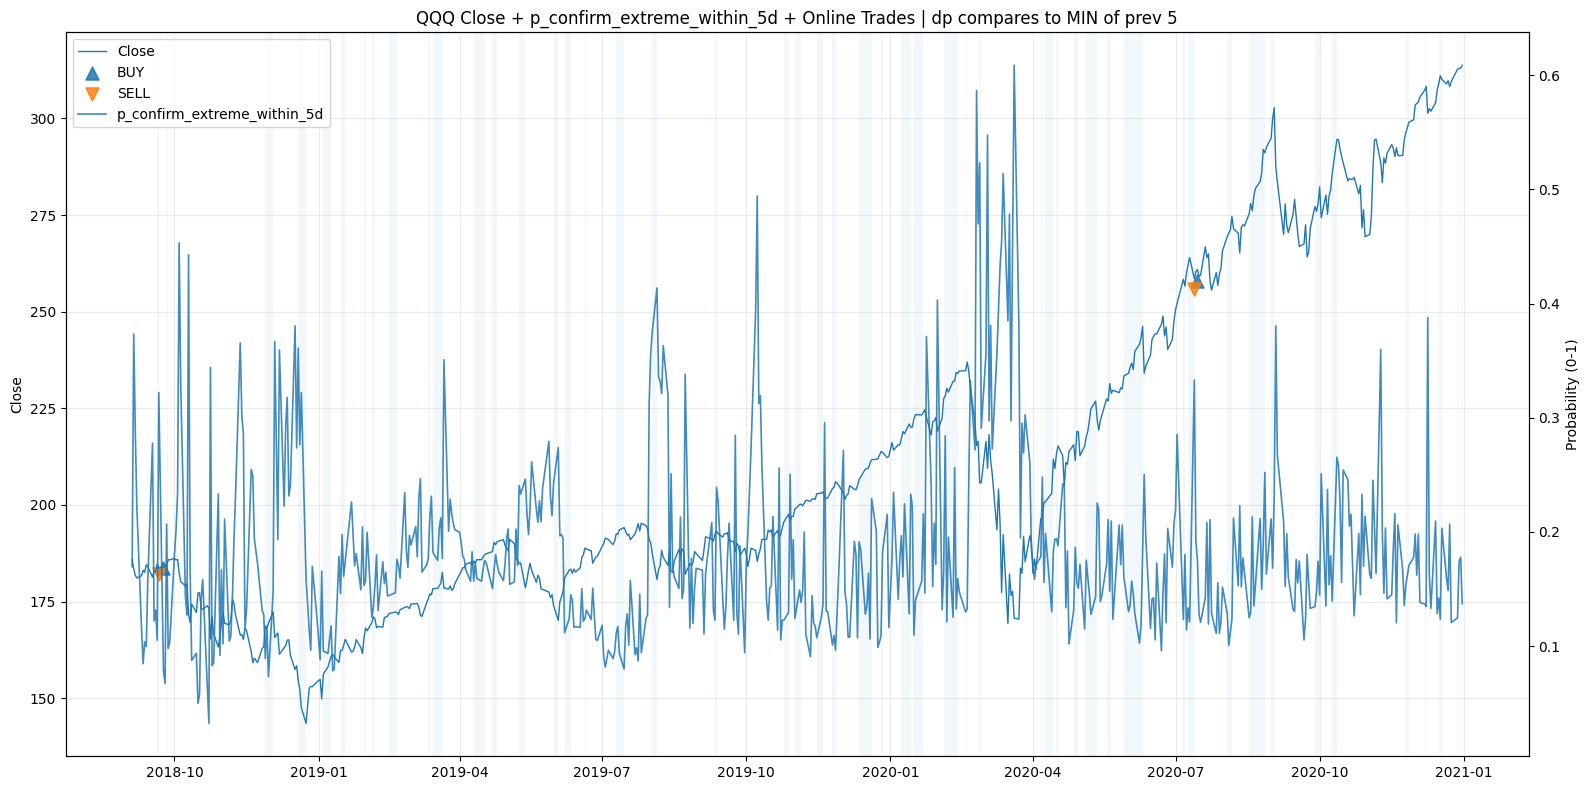

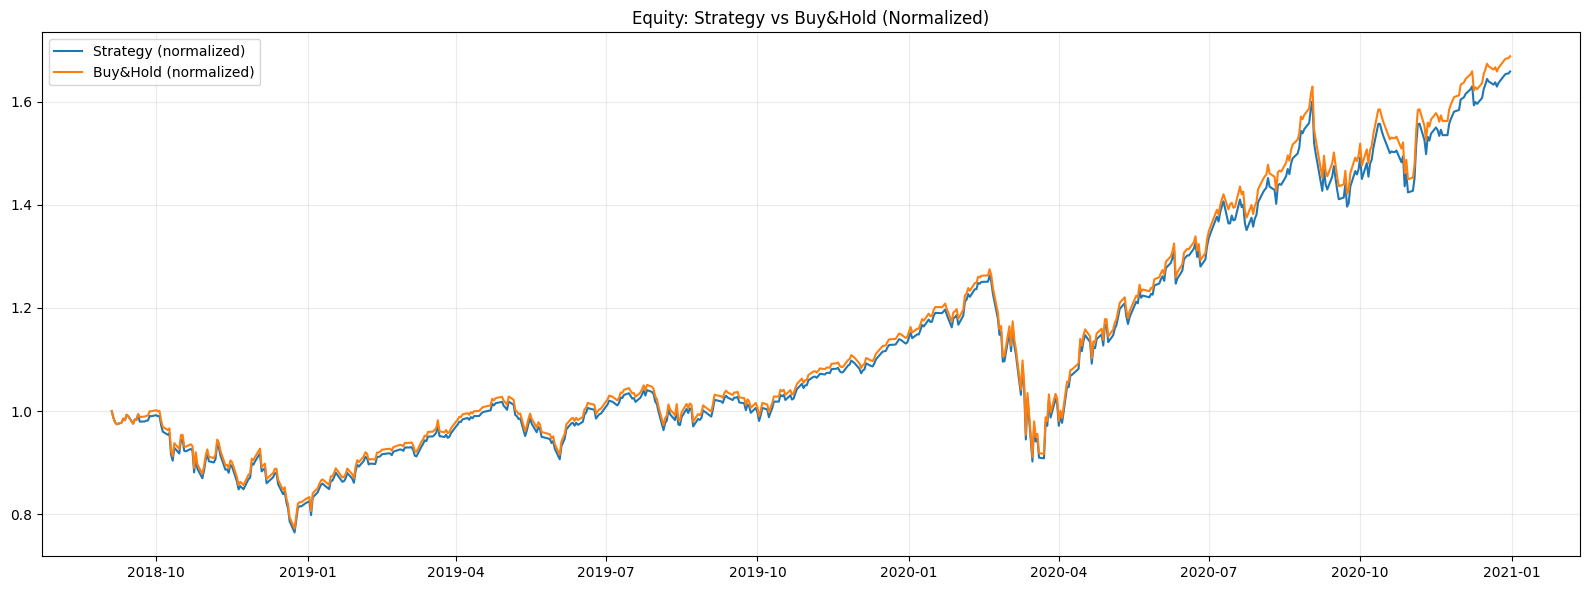

[LABELS][PROB] n=2323 pos=473 (20.36%)
[MODEL][PROB] trained=yes trained_n=2300
[BSP] total_bsp_all=740 | bsp_out=210
[TRADES] all=20 | out=4


,day,ts,side,exec_px,p,dp_vs_minK,dp_vs_maxK,regime,base_dir,reason
0,2018-09-21,2018-09-21,SELL,182.05,0.322002,0.216881,0.044235,up,sell,SELL: up | p=0.32 dp_minK=0.22
1,2018-09-24,2018-09-24,BUY,183.81,0.077945,-0.027177,-0.244057,unknown,sell,BUYBACK | p=0.08 dp_maxK=-0.24 last_sell_p=0.32
2,2020-07-13,2020-07-13,SELL,255.93,0.332889,0.218789,0.152692,up,sell,SELL: up | p=0.33 dp_minK=0.22
3,2020-07-15,2020-07-15,BUY,258.02,0.174961,0.060861,-0.157928,unknown,sell,BUYBACK | p=0.17 dp_maxK=-0.16 last_sell_p=0.33


,timestamp,open,high,low,close,p_confirm_extreme_within_5d,p_min_prev_5,p_max_prev_5,dp_vs_min_prev_5,dp_vs_max_prev_5,regime_chain,base_dir,day,action,exec_px,position,equity,bh_equity
0,2018-09-04,186.08,186.40,184.85,185.85,0.169538,0.080644,0.212024,0.088894,-0.042486,unknown,sell,2018-09-04,,NaN,1,165289.697802,168418.667875
1,2018-09-05,185.52,185.55,182.82,183.45,0.373293,0.100079,0.212024,0.273214,0.161269,unknown,sell,2018-09-05,,NaN,1,163155.206144,166243.769823
2,2018-09-06,183.53,183.75,180.58,181.81,0.288008,0.100079,0.373293,0.187929,-0.085285,unknown,sell,2018-09-06,,NaN,1,161696.636844,164757.589488
3,2018-09-07,180.50,182.67,180.44,181.11,0.221126,0.169538,0.373293,0.051588,-0.152168,unknown,sell,2018-09-07,,NaN,1,161074.076777,164123.244223
4,2018-09-10,182.15,182.25,180.73,181.72,0.115135,0.169538,0.373293,-0.054403,-0.258158,unknown,sell,2018-09-10,,NaN,1,161616.593407,164676.030811
5,2018-09-11,180.99,183.42,180.52,183.12,0.084592,0.115135,0.373293,-0.030544,-0.288701,unknown,sell,2018-09-11,,NaN,1,162861.713541,165944.721341
6,2018-09-12,182.85,182.98,181.01,182.58,0.103619,0.084592,0.373293,0.019027,-0.269674,unknown,sell,2018-09-12,,NaN,1,162381.452918,165455.369280
7,2018-09-13,183.72,184.88,183.64,184.53,0.099502,0.084592,0.288008,0.014910,-0.188507,unknown,sell,2018-09-13,,NaN,1,164115.727390,167222.473947
8,2018-09-14,184.66,184.95,183.26,183.99,0.157908,0.084592,0.221126,0.073316,-0.063218,unknown,sell,2018-09-14,,NaN,1,163635.466767,166733.121885
9,2018-09-17,183.68,183.81,181.17,181.34,0.277767,0.084592,0.157908,0.193175,0.119859,unknown,sell,2018-09-17,,NaN,1,161278.632227,164331.671953


,timestamp,open,high,low,close,p_confirm_extreme_within_5d,p_min_prev_5,p_max_prev_5,dp_vs_min_prev_5,dp_vs_max_prev_5,regime_chain,base_dir,day,action,exec_px,position,equity,bh_equity
577,2020-12-17,310.63,311.24,309.39,311.00,0.123570,0.128307,0.209527,-0.004737,-0.085957,up,sell,2020-12-17,,NaN,1,271727.118413,281830.539193
578,2020-12-18,311.66,311.98,307.61,310.06,0.203269,0.123570,0.209527,0.079699,-0.006258,up,sell,2020-12-18,,NaN,1,270905.821013,280978.704123
579,2020-12-21,306.46,309.47,303.60,308.92,0.159482,0.123570,0.209527,0.035912,-0.050045,unknown,sell,2020-12-21,,NaN,1,269909.779486,279945.627549
580,2020-12-22,309.85,310.71,306.85,309.76,0.148623,0.123570,0.203269,0.025053,-0.054646,unknown,sell,2020-12-22,,NaN,1,270643.704821,280706.841867
581,2020-12-23,309.81,310.18,308.04,308.20,0.206646,0.123570,0.203269,0.083077,0.003377,unknown,sell,2020-12-23,,NaN,1,269280.700626,279293.158133
582,2020-12-24,308.47,310.02,308.39,309.56,0.120548,0.123570,0.206646,-0.003022,-0.086099,unknown,sell,2020-12-24,,NaN,1,270468.960694,280525.600362
583,2020-12-28,312.25,313.17,310.36,312.68,0.124665,0.120548,0.206646,0.004118,-0.081981,up,sell,2020-12-28,,NaN,1,273194.969084,283352.967830
584,2020-12-29,314.05,314.69,312.03,312.96,0.173859,0.120548,0.206646,0.053311,-0.032787,up,sell,2020-12-29,,NaN,1,273439.610863,283606.705936
585,2020-12-30,314.16,314.49,312.33,312.97,0.177795,0.120548,0.206646,0.057248,-0.028851,unknown,sell,2020-12-30,,NaN,1,273448.348069,283615.768011
586,2020-12-31,312.87,314.24,311.76,313.74,0.137241,0.120548,0.206646,0.016693,-0.069406,unknown,sell,2020-12-31,,NaN,1,274121.112961,284313.547802


In [ ]:
# ============================================================
# DAILY Kline "Extreme Confirmation" Probability + ONLINE Trading (FULL Jupyter SINGLE CELL)
#
# ✅ Implements EVERYTHING you mentioned:
#
# A) Probability model (walk-forward):
#    p(t) = P( today's implied extreme is CONFIRMED within next N days )
#    Label rule:
#      base_dir(t0) = direction of latest BSP at/before t0 (buy/sell)
#      If base_dir == 'sell' (candidate TOP day):
#         y=1 if max(high in next N days) < high(t0) else 0
#      If base_dir == 'buy' (candidate BOTTOM day):
#         y=1 if min(low  in next N days) > low(t0)  else 0
#
# B) Chain-regime:
#    Uptrend:   end(BUY chain) -> end(next SELL chain)
#    Downtrend: end(SELL chain)-> end(next BUY chain)
#
# C) TRADING (online, day-by-day DURING p(t) calculation):
#    You requested to use "change in prob" vs lowest of previous K (not just yesterday).
#
#    Define (past-only):
#      p_minK(t) = min{ p(t-1..t-K) }
#      p_maxK(t) = max{ p(t-1..t-K) }
#      dp_vs_minK = p(t) - p_minK(t)     (sudden INCREASE proxy)
#      dp_vs_maxK = p(t) - p_maxK(t)     (sudden DECREASE proxy; negative big = sharp drop)
#
#    SELL (bull OR reversal up->down):
#      if dp_vs_minK >= dp_sell_jump  OR p >= p_sell_level  => SELL
#
#    BUYBACK after SOLD:
#      if dp_vs_maxK <= -dp_buyback_jump OR p <= last_sell_prob - buyback_drop => BUY
#
#    BEAR rule:
#      After a reversal-sell (up->down), wait N_buy_wait days.
#      If regime is down AND p <= (reversal_sell_prob - bear_buy_margin) => BUY
#
# D) Fixes:
#    ✅ Output only a chosen range (e.g. 2018 -> 2020-12-31) while still training from 2016.
#    ✅ Fix sklearn convergence warning: DictVectorizer + MaxAbsScaler (sparse-safe) + solver='saga'
#    ✅ Trading actually happens sooner: earlier training defaults + sane default triggers
#
# Output:
#   - daily_df_out: only [output_start, output_end], includes p, dp_vs_minK/maxK, position, equity, bh_equity
#   - trades_df_out
#   - bsp_df_out
#   - Plots (only output window)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Any, List, Optional, Tuple
from dataclasses import dataclass

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler

from sliding_window_chan import SlidingWindowChan
from ChanConfig import CChanConfig
from Common.CEnum import DATA_FIELD, KL_TYPE, AUTYPE

try:
    from Common.CEnum import DATA_SRC
except Exception:
    class DATA_SRC:
        CSV = "CSV"

from KLine.KLine_Unit import CKLine_Unit
from Common.CTime import CTime

try:
    from IPython.display import display
except Exception:
    def display(x):
        print(x)

# ----------------------------
# Chan bar builders
# ----------------------------
def to_ctime(ts) -> CTime:
    if isinstance(ts, CTime):
        return ts
    dt = pd.to_datetime(ts).to_pydatetime()
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second, auto=False)
    except Exception:
        pass
    try:
        return CTime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)
    except Exception:
        pass
    s = dt.strftime("%Y-%m-%d %H:%M:%S")
    try:
        return CTime(s, auto=False)
    except Exception:
        return CTime(s)

def build_klu(ts, o, h, l, c, v=0.0) -> CKLine_Unit:
    ct = to_ctime(ts)
    kl_dict = {
        DATA_FIELD.FIELD_TIME: ct,
        DATA_FIELD.FIELD_OPEN: float(o),
        DATA_FIELD.FIELD_HIGH: float(h),
        DATA_FIELD.FIELD_LOW:  float(l),
        DATA_FIELD.FIELD_CLOSE: float(c),
        DATA_FIELD.FIELD_VOLUME: float(v),
        "time": ct, "timestamp": ct, "datetime": ct, "dt": ct,
        "open": float(o), "high": float(h), "low": float(l), "close": float(c),
        "volume": float(v),
    }
    klu = CKLine_Unit(kl_dict)
    try:
        klu.time = ct
    except Exception:
        pass
    return klu

# ----------------------------
# CSV loader
# ----------------------------
def _pick_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    cols = list(df.columns)
    for c in candidates:
        if c in cols:
            return c
    lower_map = {c.lower(): c for c in cols}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    return None

def load_daily_csv(daily_csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(daily_csv_path)

    ts_col = _pick_col(df, ["timestamp", "date", "datetime", "time"])
    if ts_col is None:
        ts_col = df.columns[0]

    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).reset_index(drop=True)
    df = df.rename(columns={ts_col: "timestamp"})

    open_col  = _pick_col(df, ["open", "Open", "o", "O"])
    high_col  = _pick_col(df, ["high", "High", "h", "H"])
    low_col   = _pick_col(df, ["low", "Low", "l", "L"])
    close_col = _pick_col(df, ["close", "Close", "adj_close", "Adj Close", "AdjClose", "c", "C"])
    if open_col is None or close_col is None:
        raise ValueError("Daily CSV must contain open and close columns.")
    if high_col is None:
        high_col = close_col
    if low_col is None:
        low_col = close_col

    vol_col = _pick_col(df, ["volume", "Volume", "vol", "Vol", "v", "V"])

    df["_open"]  = pd.to_numeric(df[open_col], errors="coerce").astype(float)
    df["_high"]  = pd.to_numeric(df[high_col], errors="coerce").astype(float)
    df["_low"]   = pd.to_numeric(df[low_col], errors="coerce").astype(float)
    df["_close"] = pd.to_numeric(df[close_col], errors="coerce").astype(float)
    df["_vol"]   = pd.to_numeric(df[vol_col], errors="coerce").astype(float) if vol_col is not None else 0.0

    df = df.dropna(subset=["_open", "_high", "_low", "_close"]).reset_index(drop=True)
    df["ts_norm"] = df["timestamp"].dt.normalize()
    return df

# ----------------------------
# Kline features
# ----------------------------
def _safe_div(a, b, eps=1e-12):
    return a / (b + eps)

def compute_kline_features(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy().sort_values("timestamp").reset_index(drop=True)

    o = d["_open"].astype(float)
    h = d["_high"].astype(float)
    l = d["_low"].astype(float)
    c = d["_close"].astype(float)
    v = d["_vol"].astype(float)

    prev_c = c.shift(1)
    d["ret1"] = (_safe_div(c, prev_c) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    tr = pd.concat([(h-l).abs(), (h-prev_c).abs(), (l-prev_c).abs()], axis=1).max(axis=1)
    d["tr"] = tr.fillna(0.0)
    d["atr_14"] = d["tr"].rolling(14).mean().bfill().fillna(0.0)

    d["range"] = (h - l).fillna(0.0)
    d["range_over_atr"] = _safe_div(d["range"], d["atr_14"]).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    rng = (h - l).replace(0.0, np.nan)
    d["close_pos"] = ((c - l) / rng).replace([np.inf, -np.inf], np.nan).fillna(0.5)

    d["gap"] = (_safe_div(o, prev_c) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [5, 10, 20, 40]:
        d[f"ret_{w}"] = (_safe_div(c, c.shift(w)) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        d[f"vol_{w}"] = d["ret1"].rolling(w).std().replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [20, 50, 100]:
        ma = c.rolling(w).mean()
        d[f"above_ma_{w}"] = (_safe_div(c, ma) - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    for w in [5, 20, 60]:
        m = v.rolling(w).mean()
        s = v.rolling(w).std()
        d[f"vol_ratio_{w}"] = _safe_div(v, m).replace([np.inf, -np.inf], np.nan).fillna(1.0)
        d[f"vol_z_{w}"] = ((v - m) / (s + 1e-12)).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    d["vol_jump"] = _safe_div(v, v.shift(1)).replace([np.inf, -np.inf], np.nan).fillna(1.0)

    def _slope_log(x):
        x = np.asarray(x, dtype=float)
        x = np.log(np.maximum(x, 1e-12))
        t = np.arange(len(x), dtype=float)
        t = t - t.mean()
        x = x - x.mean()
        den = (t*t).sum()
        return 0.0 if den <= 0 else float((t*x).sum() / den)

    d["slope40"] = d["_close"].rolling(40).apply(_slope_log, raw=False).fillna(0.0)
    return d

KLINE_KEYS = [
    "ret1","ret_5","ret_10","ret_20","ret_40",
    "vol_5","vol_10","vol_20","vol_40",
    "atr_14","range_over_atr","close_pos","gap",
    "vol_ratio_5","vol_ratio_20","vol_ratio_60",
    "vol_z_20","vol_z_60","vol_jump",
    "above_ma_20","above_ma_50","above_ma_100",
    "slope40",
]
def make_kline_dict(kline_row: pd.Series) -> Dict[str, float]:
    d = {}
    for k in KLINE_KEYS:
        val = kline_row[k] if k in kline_row.index else 0.0
        d[f"k_{k}"] = float(val) if np.isfinite(val) else 0.0
    return d

# ----------------------------
# BSP helpers
# ----------------------------
def normalize_bsp_row(r: Dict[str, Any]) -> Dict[str, Any]:
    rr = dict(r)
    if "direction" not in rr or rr["direction"] is None:
        if rr.get("is_buy", None) is not None:
            rr["direction"] = "buy" if bool(rr["is_buy"]) else "sell"
        else:
            rr["direction"] = "buy"
    rr["direction"] = str(rr["direction"]).lower()
    if "bsp_type" in rr and rr["bsp_type"] is not None:
        rr["bsp_type"] = str(rr["bsp_type"]).lower()
    else:
        rr["bsp_type"] = "?"
    return rr

def extract_bsp_rows_from_chan(chan_obj) -> List[Dict[str, Any]]:
    if hasattr(chan_obj, "export_new_historical_bsp_to_list"):
        out = chan_obj.export_new_historical_bsp_to_list()
        return out if out else []
    if hasattr(chan_obj, "export_new_bsp_to_list"):
        out = chan_obj.export_new_bsp_to_list()
        return out if out else []
    return []

def latest_bsp_dir_up_to(bsp_rows: List[Dict[str, Any]], ts: pd.Timestamp) -> Optional[str]:
    past = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= ts]
    if not past:
        return None
    past = sorted(past, key=lambda x: pd.to_datetime(x["timestamp"]))
    return str(past[-1].get("direction", "")).lower()

# ----------------------------
# BSP context features
# ----------------------------
def make_daily_bsp_context(bsp_hist: List[Dict[str, Any]], cur_ts: pd.Timestamp, window_days: int = 60) -> Dict[str, float]:
    past = [r for r in bsp_hist if pd.to_datetime(r["timestamp"]) <= cur_ts]
    past = sorted(past, key=lambda x: pd.to_datetime(x["timestamp"]))
    if not past:
        return {
            "ctx_has_bsp": 0.0,
            "ctx_last_dir_buy": 0.0,
            "ctx_last_dir_sell": 0.0,
            "ctx_days_since_last_bsp": 999.0,
            "ctx_days_since_last_buy": 999.0,
            "ctx_days_since_last_sell": 999.0,
            "ctx_density_total": 0.0,
            "ctx_density_buy": 0.0,
            "ctx_density_sell": 0.0,
            "ctx_density_imb": 0.0,
        }
    last = past[-1]
    last_dir = str(last.get("direction", "")).lower()
    days_since_last = float((cur_ts.normalize() - pd.to_datetime(last["timestamp"]).normalize()).days)

    def _days_since(target: str) -> float:
        for r in reversed(past):
            if str(r.get("direction", "")).lower() == target:
                return float((cur_ts.normalize() - pd.to_datetime(r["timestamp"]).normalize()).days)
        return 999.0

    start = cur_ts.normalize() - pd.Timedelta(days=int(window_days))
    recent = [r for r in past if pd.to_datetime(r["timestamp"]).normalize() >= start]
    buy = sum(1 for r in recent if str(r.get("direction", "")).lower() == "buy")
    sell = sum(1 for r in recent if str(r.get("direction", "")).lower() == "sell")
    tot = max(1.0, float(buy + sell))

    return {
        "ctx_has_bsp": 1.0,
        "ctx_last_dir_buy": 1.0 if last_dir == "buy" else 0.0,
        "ctx_last_dir_sell": 1.0 if last_dir == "sell" else 0.0,
        "ctx_days_since_last_bsp": days_since_last,
        "ctx_days_since_last_buy": _days_since("buy"),
        "ctx_days_since_last_sell": _days_since("sell"),
        "ctx_density_total": float(len(recent)),
        "ctx_density_buy": float(buy),
        "ctx_density_sell": float(sell),
        "ctx_density_imb": float((sell - buy) / tot),
    }

def make_daily_features(kline_row: pd.Series,
                        bsp_hist_up_to_day: List[Dict[str, Any]],
                        p_val: float,
                        dp_minK: float,
                        dp_maxK: float,
                        regime: str) -> Dict[str, float]:
    feats: Dict[str, float] = {}
    feats.update(make_kline_dict(kline_row))
    ts = pd.to_datetime(kline_row["timestamp"])
    feats.update(make_daily_bsp_context(bsp_hist_up_to_day, ts, window_days=60))
    feats["p"] = float(p_val) if np.isfinite(p_val) else 0.0
    feats["dp_minK"] = float(dp_minK) if np.isfinite(dp_minK) else 0.0
    feats["dp_maxK"] = float(dp_maxK) if np.isfinite(dp_maxK) else 0.0
    rg = str(regime).lower()
    feats["rg_up"] = 1.0 if rg == "up" else 0.0
    feats["rg_down"] = 1.0 if rg == "down" else 0.0
    feats["rg_unknown"] = 1.0 if rg not in ("up", "down") else 0.0
    return feats

# ----------------------------
# Confirmation label
# ----------------------------
def label_top_bottom_for_day(df_feat: pd.DataFrame, day_idx: int, N: int, base_dir: str) -> Optional[int]:
    if N <= 0:
        return None
    if day_idx + N >= len(df_feat):
        return None
    h0 = float(df_feat.loc[day_idx, "_high"])
    l0 = float(df_feat.loc[day_idx, "_low"])
    fut = df_feat.loc[day_idx+1:day_idx+N]
    if fut.empty:
        return None
    if base_dir == "sell":
        mx = float(fut["_high"].max())
        return 1 if mx < h0 else 0
    if base_dir == "buy":
        mn = float(fut["_low"].min())
        return 1 if mn > l0 else 0
    return None

# ----------------------------
# Chain regimes
# ----------------------------
def compute_chain_endpoints(bsp_rows: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    if not bsp_rows:
        return []
    bsps = sorted(bsp_rows, key=lambda r: pd.to_datetime(r["timestamp"]))
    ends = []
    cur_dir = str(bsps[0].get("direction", "")).lower()
    cur_end = bsps[0]
    cur_end_i = 0
    for i in range(1, len(bsps)):
        d = str(bsps[i].get("direction", "")).lower()
        if d == cur_dir:
            cur_end = bsps[i]
            cur_end_i = i
        else:
            ends.append({"end_ts": pd.to_datetime(cur_end["timestamp"]).normalize(), "end_dir": cur_dir, "end_i": cur_end_i})
            cur_dir = d
            cur_end = bsps[i]
            cur_end_i = i
    ends.append({"end_ts": pd.to_datetime(cur_end["timestamp"]).normalize(), "end_dir": cur_dir, "end_i": cur_end_i})
    return ends

def regime_for_day_from_ends(day_norm: pd.Timestamp, ends: List[Dict[str, Any]]) -> str:
    if len(ends) < 2:
        return "unknown"
    for k in range(len(ends) - 1):
        a = ends[k]; b = ends[k+1]
        a_ts, a_dir = a["end_ts"], a["end_dir"]
        b_ts, b_dir = b["end_ts"], b["end_dir"]
        if (day_norm >= a_ts) and (day_norm <= b_ts):
            if a_dir == "buy" and b_dir == "sell":
                return "up"
            if a_dir == "sell" and b_dir == "buy":
                return "down"
    return "unknown"

# ----------------------------
# Model helpers (convergence-safe)
# ----------------------------
def fit_prob_model_dicts(X_dicts: List[Dict[str, float]], y: np.ndarray, verbose: bool=False):
    base = Pipeline([
        ("vec", DictVectorizer(sparse=True)),
        ("scaler", MaxAbsScaler()),  # sparse-safe scaling
        ("lr", LogisticRegression(
            max_iter=8000,
            class_weight="balanced",
            solver="saga",
            C=0.5,
            n_jobs=-1
        ))
    ])
    uniq, counts = np.unique(y, return_counts=True)
    if len(uniq) < 2:
        raise ValueError("Only one class in y so far.")
    min_count = int(counts.min())

    if min_count >= 5:
        cal = CalibratedClassifierCV(base, method="sigmoid", cv=3)
        cal.fit(X_dicts, y)
        return cal
    elif min_count >= 3:
        cal = CalibratedClassifierCV(base, method="sigmoid", cv=2)
        cal.fit(X_dicts, y)
        return cal
    else:
        base.fit(X_dicts, y)
        return base

def predict_prob(model, X_dicts: List[Dict[str, float]]) -> np.ndarray:
    return model.predict_proba(X_dicts)[:, 1]

@dataclass
class OnlineState:
    model: Optional[Any] = None
    new_labels: int = 0
    trained_n: int = 0

# ----------------------------
# Main runner
# ----------------------------
def run_daily_prob_and_trade(
    daily_csv_path: str,
    code: str = "QQQ",

    # Training feed start (keep earlier to build Chan/BSP history)
    daily_chan_start: str = "2016-06-01",

    # Plot range (what you see)
    plot_start: str = "2018-09-01",
    plot_end: str   = "2020-12-31",

    # OUTPUT range (what is returned)
    output_start: str = "2018-09-01",
    output_end: str   = "2020-12-31",

    daily_chan_max_klines: int = 800,

    # confirmation horizon
    N: int = 5,

    # Probability model training
    min_labeled_days_to_train: int = 200,
    retrain_every_new_labels: int = 25,

    # "change vs lowest of previous K"
    dp_lookback: int = 5,

    # Trading thresholds (interpreted as:
    #   dp_sell_jump compares p(t) - min(p(t-1..t-K))
    #   dp_buyback_jump compares max(p(t-1..t-K)) - p(t)  (via dp_vs_maxK <= -dp_buyback_jump)
    # dp_sell_jump: float = 0.20,
    # p_sell_level: float = 0.35,
    # dp_buyback_jump: float = 0.20,
    # buyback_drop: float = 0.15,
    # N_buy_wait: int = 5,
    # bear_buy_margin: float = 0.00,
    p_sell_level=0.35,
    p_buy_level=0.20,

    # Execution
    initial_capital: float = 100000.0,
    fee_pct: float = 0.0,
    trade_at: str = "next_open",   # "next_open" or "close"

    # Start invested or not
    start_in_market: bool = True,

    verbose: bool = True,
    shade_regimes: bool = True,
):
    # ----------------------------
    # Load
    # ----------------------------
    df = load_daily_csv(daily_csv_path)
    df = df[df["timestamp"] >= pd.to_datetime(daily_chan_start)].copy().reset_index(drop=True)
    if df.empty:
        raise ValueError("No daily bars after daily_chan_start.")
    df_feat = compute_kline_features(df)

    plot_s = pd.to_datetime(plot_start)
    plot_e = pd.to_datetime(plot_end) + pd.Timedelta(hours=23, minutes=59, seconds=59)
    out_s = pd.to_datetime(output_start)
    out_e = pd.to_datetime(output_end) + pd.Timedelta(hours=23, minutes=59, seconds=59)

    # ----------------------------
    # Chan config
    # ----------------------------
    config = CChanConfig({
        "cal_demark": True,
        "cal_kdj": True,
        "cal_dmi": True,
        "cal_rsi": True,
        "cal_rsl": True,
        "cal_demand_index": True,
        "cal_adline": True,
        "cal_bb_vals": True,
        "cal_kc_vals": True,
        "cal_starc_vals": True,
        "bi_strict": True,
        "trigger_step": True,
        "skip_step": 0,
        "divergence_rate": float("inf"),
        "bsp2_follow_1": True,
        "bsp3_follow_1": False,
        "min_zs_cnt": 0,
        "bs1_peak": False,
        "macd_algo": "peak",
        "bs_type": "1,2,3a,1p,2s,3b",
        "print_warning": False,
        "zs_algo": "normal",
    })

    daily_chan = SlidingWindowChan(
        code=code,
        begin_time=None,
        end_time=None,
        data_src=getattr(DATA_SRC, "CSV", "CSV"),
        lv_list=[KL_TYPE.K_DAY],
        config=config,
        autype=AUTYPE.QFQ,
        max_klines=int(daily_chan_max_klines),
    )

    # ----------------------------
    # Online prob buffers
    # ----------------------------
    bsp_rows: List[Dict[str, Any]] = []
    seen_bsp = set()

    X_days: List[Dict[str, float]] = []
    y_days: List[int] = []
    st = OnlineState()

    pending_day_idx: List[int] = []

    p_series = np.full(len(df_feat), np.nan, dtype=float)
    dp_vs_minK_series = np.full(len(df_feat), np.nan, dtype=float)
    dp_vs_maxK_series = np.full(len(df_feat), np.nan, dtype=float)
    p_minK_series = np.full(len(df_feat), np.nan, dtype=float)
    p_maxK_series = np.full(len(df_feat), np.nan, dtype=float)
    regime_series = np.array(["unknown"] * len(df_feat), dtype=object)
    base_dir_series = np.array([None] * len(df_feat), dtype=object)

    # ----------------------------
    # Trading state
    # ----------------------------
    def exec_price(i: int) -> float:
        if trade_at == "close":
            return float(df_feat.loc[i, "_close"])
        # next_open
        if i + 1 >= len(df_feat):
            return np.nan
        return float(df_feat.loc[i + 1, "_open"])

    pos = 1 if start_in_market else 0
    if pos == 1:
        cash = 0.0
        qty = float(initial_capital) / float(df_feat.loc[0, "_close"])
    else:
        cash = float(initial_capital)
        qty = 0.0

    last_sell_prob = np.nan
    last_sell_day = None
    reversal_sell_prob = np.nan
    reversal_sell_day = None
    prev_regime = "unknown"

    trades: List[Dict[str, Any]] = []

    def maybe_train():
        if len(y_days) < int(min_labeled_days_to_train):
            return
        if st.model is None or st.new_labels >= int(retrain_every_new_labels):
            y = np.asarray(y_days, dtype=int)
            if len(np.unique(y)) < 2:
                return
            try:
                st.model = fit_prob_model_dicts(X_days, y)
                st.trained_n = len(y)
                if verbose:
                    print(f"[TRAIN][PROB] n={len(y)} pos={int(y.sum())} ({y.mean():.2%})")
                st.new_labels = 0
            except ValueError as e:
                if verbose:
                    print(f"[TRAIN][PROB] skipped: {e}")

    # ----------------------------
    # Walk-forward
    # ----------------------------
    for i in range(len(df_feat)):
        ts = pd.to_datetime(df_feat.loc[i, "timestamp"])
        day_norm = ts.normalize()

        # feed chan
        daily_chan.process_new_kline(build_klu(
            ts=ts,
            o=float(df_feat.loc[i, "_open"]),
            h=float(df_feat.loc[i, "_high"]),
            l=float(df_feat.loc[i, "_low"]),
            c=float(df_feat.loc[i, "_close"]),
            v=float(df_feat.loc[i, "_vol"]),
        ))

        # collect BSPs
        new_bsp = extract_bsp_rows_from_chan(daily_chan)
        if new_bsp:
            for r0 in new_bsp:
                r = normalize_bsp_row(dict(r0))
                r.setdefault("timestamp", ts)
                key = (pd.to_datetime(r["timestamp"]).strftime("%Y-%m-%d"), r["direction"], r.get("bsp_type", "?"))
                if key in seen_bsp:
                    continue
                seen_bsp.add(key)
                bsp_rows.append(r)

        # regime + base_dir today
        ends = compute_chain_endpoints(bsp_rows)
        regime = regime_for_day_from_ends(day_norm, ends)
        regime_series[i] = regime
        base_dir_today = latest_bsp_dir_up_to(bsp_rows, ts)
        base_dir_series[i] = base_dir_today

        # predict p(t)
        p_val = np.nan
        if st.model is not None:
            bsp_hist = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= ts]
            # dp_minK/maxK not yet known -> set 0; model will still work
            feat_i = make_daily_features(df_feat.loc[i], bsp_hist, p_val=0.0, dp_minK=0.0, dp_maxK=0.0, regime=regime)
            p_val = float(predict_prob(st.model, [feat_i])[0])
            p_series[i] = p_val

        # compute p_minK / p_maxK and dp_vs_minK / dp_vs_maxK (past-only)
        lb = int(dp_lookback)
        p_minK = np.nan
        p_maxK = np.nan
        if lb > 0 and i >= 1 and np.isfinite(p_val):
            start = max(0, i - lb)
            prev = pd.Series(p_series[start:i]).dropna()  # strictly previous
            if len(prev) > 0:
                p_minK = float(prev.min())
                p_maxK = float(prev.max())
        p_minK_series[i] = p_minK
        p_maxK_series[i] = p_maxK

        dp_vs_minK = (p_val - p_minK) if (np.isfinite(p_val) and np.isfinite(p_minK)) else np.nan
        dp_vs_maxK = (p_val - p_maxK) if (np.isfinite(p_val) and np.isfinite(p_maxK)) else np.nan
        dp_vs_minK_series[i] = dp_vs_minK
        dp_vs_maxK_series[i] = dp_vs_maxK

        # finalize labels for older days (for training)
        pending_day_idx.append(i)
        while pending_day_idx and i >= pending_day_idx[0] + int(N):
            j = pending_day_idx.pop(0)
            t0 = pd.to_datetime(df_feat.loc[j, "timestamp"])
            base_dir_j = latest_bsp_dir_up_to(bsp_rows, t0)
            if base_dir_j not in ("buy", "sell"):
                continue
            y = label_top_bottom_for_day(df_feat, j, int(N), base_dir_j)
            if y is None:
                continue

            # features for day j: use p(j) if known else 0, and dp_vs_minK/maxK if known else 0
            pj = p_series[j]
            dminj = dp_vs_minK_series[j]
            dmaxj = dp_vs_maxK_series[j]

            ends_j = compute_chain_endpoints([r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= t0])
            regime_j = regime_for_day_from_ends(t0.normalize(), ends_j)

            bsp_hist_j = [r for r in bsp_rows if pd.to_datetime(r["timestamp"]) <= t0]
            feat_j = make_daily_features(
                df_feat.loc[j],
                bsp_hist_j,
                p_val=float(pj) if np.isfinite(pj) else 0.0,
                dp_minK=float(dminj) if np.isfinite(dminj) else 0.0,
                dp_maxK=float(dmaxj) if np.isfinite(dmaxj) else 0.0,
                regime=regime_j
            )

            X_days.append(feat_j)
            y_days.append(int(y))
            st.new_labels += 1

        # train prob model
        maybe_train()

        # ============================
        # TRADING (online)
        # ============================
        if not np.isfinite(p_val):
            prev_regime = regime
            continue

        px = exec_price(i)
        if not np.isfinite(px) or px <= 0:
            prev_regime = regime
            continue

        #is_reversal_up_to_down = (str(prev_regime).lower() == "up") and (str(regime).lower() == "down")

        # SELL: bull OR reversal up->down
        if pos == 1 and (p_val > float(p_sell_level)):
            notional = qty * px
            fee = notional * float(fee_pct)
            cash += (notional - fee)
            qty = 0.0
            pos = 0

            last_sell_prob = float(p_val)
            last_sell_day = day_norm

            trades.append({
                "day": day_norm, "ts": ts, "side": "SELL", "exec_px": float(px),
                "p": float(p_val),
                "dp_vs_minK": float(dp_vs_minK) if np.isfinite(dp_vs_minK) else np.nan,
                "dp_vs_maxK": float(dp_vs_maxK) if np.isfinite(dp_vs_maxK) else np.nan,
                "regime": str(regime), "base_dir": str(base_dir_today),
                "reason": f"SELL: p>{float(p_sell_level):.2f} | p={p_val:.2f}"
            })

        # BUY condition: p < 0.20 (or your p_buy_level)
        if pos == 0 and (p_val < float(p_buy_level)):
            notional = cash
            fee = notional * float(fee_pct)
            spend = notional + fee
            if spend > cash:
                notional = cash / (1.0 + float(fee_pct))
                fee = notional * float(fee_pct)
                spend = notional + fee

            if notional > 0:
                qty = notional / px
                cash -= spend
                pos = 1

                trades.append({
                    "day": day_norm, "ts": ts, "side": "BUY", "exec_px": float(px),
                    "p": float(p_val),
                    "dp_vs_minK": float(dp_vs_minK) if np.isfinite(dp_vs_minK) else np.nan,
                    "dp_vs_maxK": float(dp_vs_maxK) if np.isfinite(dp_vs_maxK) else np.nan,
                    "regime": str(regime), "base_dir": str(base_dir_today),
                    "reason": f"BUY: p<{float(p_buy_level):.2f} | p={p_val:.2f}"
                })

        prev_regime = regime

    # ----------------------------
    # Build final daily_df (full)
    # ----------------------------
    pcol = f"p_confirm_extreme_within_{N}d"
    daily_df = pd.DataFrame({
        "timestamp": pd.to_datetime(df_feat["timestamp"]),
        "open": df_feat["_open"].astype(float).to_numpy(),
        "high": df_feat["_high"].astype(float).to_numpy(),
        "low":  df_feat["_low"].astype(float).to_numpy(),
        "close": df_feat["_close"].astype(float).to_numpy(),
        pcol: p_series,
        f"p_min_prev_{dp_lookback}": p_minK_series,
        f"p_max_prev_{dp_lookback}": p_maxK_series,
        f"dp_vs_min_prev_{dp_lookback}": dp_vs_minK_series,
        f"dp_vs_max_prev_{dp_lookback}": dp_vs_maxK_series,
        "regime_chain": regime_series,
        "base_dir": base_dir_series,
    })

    trades_df = pd.DataFrame(trades)

    # ----------------------------
    # Replay equity (so daily series aligns)
    # ----------------------------
    d = daily_df.copy().sort_values("timestamp").reset_index(drop=True)
    d["day"] = d["timestamp"].dt.normalize()
    d["action"] = ""
    d["exec_px"] = np.nan

    if not trades_df.empty:
        tmap = trades_df.groupby("day").last().reset_index()
        mp_px = dict(zip(tmap["day"], tmap["exec_px"]))
        mp_side = dict(zip(tmap["day"], tmap["side"]))
        d["exec_px"] = d["day"].map(mp_px)
        d["action"] = d["day"].map(mp_side).fillna("")

    cash2 = float(initial_capital)
    pos2 = 1 if start_in_market else 0
    qty2 = (cash2 / float(d.loc[0, "close"])) if pos2 == 1 else 0.0
    if pos2 == 1:
        cash2 = 0.0

    equity = []
    position = []
    for i in range(len(d)):
        close = float(d.loc[i, "close"])
        side = str(d.loc[i, "action"])
        px = d.loc[i, "exec_px"]

        if side == "SELL" and pos2 == 1 and np.isfinite(px):
            notional = qty2 * float(px)
            fee = notional * float(fee_pct)
            cash2 += (notional - fee)
            qty2 = 0.0
            pos2 = 0

        if side == "BUY" and pos2 == 0 and np.isfinite(px):
            notional = cash2
            fee = notional * float(fee_pct)
            spend = notional + fee
            if spend > cash2:
                notional = cash2 / (1.0 + float(fee_pct))
                fee = notional * float(fee_pct)
                spend = notional + fee
            qty2 = notional / float(px) if float(px) > 0 else 0.0
            cash2 -= spend
            pos2 = 1

        eq = cash2 + qty2 * close
        equity.append(eq)
        position.append(pos2)

    d["position"] = position
    d["equity"] = equity

    # buy & hold baseline
    bh0 = float(d.loc[0, "close"])
    d["bh_equity"] = float(initial_capital) * (d["close"] / (bh0 + 1e-12))

    # ----------------------------
    # Slice OUTPUT range only (your request)
    # ----------------------------
    mask_out = (d["timestamp"] >= out_s) & (d["timestamp"] <= out_e)
    d_out = d.loc[mask_out].copy().reset_index(drop=True)

    if not trades_df.empty:
        trades_out = trades_df[(trades_df["ts"] >= out_s) & (trades_df["ts"] <= out_e)].copy().reset_index(drop=True)
    else:
        trades_out = trades_df

    bsp_all = pd.DataFrame(bsp_rows)
    if not bsp_all.empty:
        bsp_all["timestamp"] = pd.to_datetime(bsp_all["timestamp"], errors="coerce")
        bsp_out = bsp_all[(bsp_all["timestamp"] >= out_s) & (bsp_all["timestamp"] <= out_e)].copy().reset_index(drop=True)
    else:
        bsp_out = bsp_all

    # ----------------------------
    # Plot only OUTPUT window (price + p + trades)
    # ----------------------------
    plot_mask = (d_out["timestamp"] >= plot_s) & (d_out["timestamp"] <= plot_e)
    dp = d_out.loc[plot_mask].copy()

    plt.figure(figsize=(16, 8))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    ax1.plot(dp["timestamp"], dp["close"], linewidth=1.0, label="Close")
    ax2.plot(dp["timestamp"], dp[pcol], linewidth=1.2, alpha=0.85, label=pcol)

    if shade_regimes and len(dp):
        up_mask = dp["regime_chain"].astype(str).str.lower().eq("up").to_numpy()
        dn_mask = dp["regime_chain"].astype(str).str.lower().eq("down").to_numpy()

        def shade(mask, alpha):
            in_span = False
            start = None
            for k in range(len(mask)):
                if mask[k] and not in_span:
                    in_span = True
                    start = dp["timestamp"].iloc[k]
                if in_span and (k == len(mask)-1 or not mask[k+1]):
                    end = dp["timestamp"].iloc[k]
                    ax1.axvspan(start, end, alpha=alpha)
                    in_span = False

        shade(up_mask, 0.06)
        shade(dn_mask, 0.06)

    if not trades_out.empty:
        buys = trades_out[trades_out["side"] == "BUY"]
        sells = trades_out[trades_out["side"] == "SELL"]
        if len(buys):
            ax1.scatter(buys["ts"], buys["exec_px"], marker="^", s=90, alpha=0.85, label="BUY")
        if len(sells):
            ax1.scatter(sells["ts"], sells["exec_px"], marker="v", s=90, alpha=0.85, label="SELL")

    ax1.set_title(f"{code} Close + {pcol} + Online Trades | dp compares to MIN of prev {dp_lookback}")
    ax1.set_ylabel("Close")
    ax2.set_ylabel("Probability (0-1)")
    h1,l1 = ax1.get_legend_handles_labels()
    h2,l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper left")
    ax1.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.plot(dp["timestamp"], dp["equity"] / float(dp["equity"].iloc[0]), label="Strategy (normalized)")
    plt.plot(dp["timestamp"], dp["bh_equity"] / float(dp["bh_equity"].iloc[0]), label="Buy&Hold (normalized)")
    plt.title("Equity: Strategy vs Buy&Hold (Normalized)")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    if verbose:
        y = np.asarray(y_days, dtype=int) if len(y_days) else np.array([], dtype=int)
        if len(y):
            print(f"[LABELS][PROB] n={len(y)} pos={int(y.sum())} ({y.mean():.2%})")
        print(f"[MODEL][PROB] trained={'yes' if st.model is not None else 'no'} trained_n={st.trained_n}")
        print(f"[BSP] total_bsp_all={len(bsp_rows)} | bsp_out={len(bsp_out)}")
        print(f"[TRADES] all={len(trades_df)} | out={len(trades_out)}")

    return d_out, trades_out, bsp_out

# ============================================================
# RUN (defaults match your target window)
# ============================================================
daily_df_out, trades_df_out, bsp_df_out = run_daily_prob_and_trade(
    daily_csv_path="DataAPI/data/QQQ_DAY.csv",
    code="QQQ",

    # train/feed history (keep early)
    daily_chan_start="2016-06-01",

    # what you SEE
    plot_start="2018-09-01",
    plot_end="2020-12-31",

    # what you RETURN
    output_start="2018-09-01",
    output_end="2020-12-31",

    daily_chan_max_klines=800,

    # confirmation horizon
    N=5,

    # train earlier so p exists sooner
    min_labeled_days_to_train=200,
    retrain_every_new_labels=25,

    # compare p(t) to MIN/MAX of previous K
    dp_lookback=5,

    # your example rules
    dp_sell_jump=0.20,
    p_sell_level=0.35,
    dp_buyback_jump=0.20,
    buyback_drop=0.15,
    N_buy_wait=5,
    bear_buy_margin=0.00,

    initial_capital=100000.0,
    fee_pct=0.0,
    trade_at="next_open",
    start_in_market=True,

    verbose=True,
    shade_regimes=True,
)

display(trades_df_out.head(50))
display(daily_df_out.head(10))
display(daily_df_out.tail(10))


In [9]:
display(trades_df.head(300))
display(daily_df_traded.head(300))
display(daily_df_traded.tail(300))
daily_df_traded.to_csv("daily_df_traded.csv", index=False)

,day,ts,side,exec_px,p,dp,regime,base_dir,reason
0,2020-07-13,2020-07-13,SELL,255.93,0.360858,0.204571,up,sell,SELL: up p=0.36 dp=0.20
1,2020-07-15,2020-07-15,BUY,258.02,0.188534,-0.027636,unknown,sell,BUYBACK: p=0.19 dp=-0.03 last_sell_p=0.36
2,2021-11-22,2021-11-22,SELL,398.11,0.430249,0.257246,up,sell,SELL: up p=0.43 dp=0.26
3,2021-11-23,2021-11-23,BUY,394.93,0.260796,-0.169453,unknown,sell,BUYBACK: p=0.26 dp=-0.17 last_sell_p=0.43
4,2023-02-01,2023-02-01,SELL,307.57,0.358053,0.192128,up,sell,SELL: up p=0.36 dp=0.19
5,2023-02-06,2023-02-06,BUY,303.46,0.226414,-0.203084,unknown,sell,BUYBACK: p=0.23 dp=-0.20 last_sell_p=0.36
6,2023-03-22,2023-03-22,SELL,309.92,0.464035,0.294283,up,sell,SELL: up p=0.46 dp=0.29
7,2023-03-24,2023-03-24,BUY,311.60,0.222859,-0.213130,unknown,sell,BUYBACK: p=0.22 dp=-0.21 last_sell_p=0.46
8,2023-05-26,2023-05-26,SELL,352.71,0.355505,0.086746,up,sell,SELL: up p=0.36 dp=0.09
9,2023-06-08,2023-06-08,BUY,354.63,0.235541,-0.360294,unknown,sell,BUYBACK: p=0.24 dp=-0.36 last_sell_p=0.36


,timestamp,open,high,low,close,p_confirm_extreme_within_5d,dp_p_confirm_extreme_within_5d,regime_chain,base_dir,day,exec_px,action,position,equity,bh_equity
0,2016-06-01,110.00,110.60,109.91,110.35,NaN,NaN,unknown,None,2016-06-01,NaN,,1,100000.000000,100000.000000
1,2016-06-02,110.13,110.59,109.53,110.58,NaN,NaN,unknown,None,2016-06-02,NaN,,1,100208.427730,100208.427730
2,2016-06-03,110.37,110.42,109.34,110.06,NaN,NaN,unknown,None,2016-06-03,NaN,,1,99737.199819,99737.199819
3,2016-06-06,110.26,110.75,110.07,110.46,NaN,NaN,unknown,None,2016-06-06,NaN,,1,100099.682827,100099.682827
4,2016-06-07,110.52,110.63,110.13,110.18,NaN,NaN,unknown,None,2016-06-07,NaN,,1,99845.944721,99845.944721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2017-08-02,144.49,144.52,142.61,143.95,NaN,NaN,up,sell,2017-08-02,NaN,,1,130448.572723,130448.572723
296,2017-08-03,144.09,144.17,143.13,143.39,NaN,NaN,up,sell,2017-08-03,NaN,,1,129941.096511,129941.096511
297,2017-08-04,143.71,143.97,143.06,143.65,NaN,NaN,up,sell,2017-08-04,NaN,,1,130176.710467,130176.710467
298,2017-08-07,143.91,144.56,143.71,144.56,NaN,NaN,up,sell,2017-08-07,NaN,,1,131001.359311,131001.359311


,timestamp,open,high,low,close,p_confirm_extreme_within_5d,dp_p_confirm_extreme_within_5d,regime_chain,base_dir,day,exec_px,action,position,equity,bh_equity
2107,2024-10-15,497.83,498.50,488.6800,490.85,0.473760,0.278121,up,sell,2024-10-15,NaN,,1,450742.466286,444811.961939
2108,2024-10-16,491.18,491.69,487.5700,490.91,0.218655,-0.255105,up,sell,2024-10-16,NaN,,1,450797.563664,444866.334391
2109,2024-10-17,496.44,496.49,491.1901,491.25,0.372580,0.153925,up,sell,2024-10-17,NaN,,1,451109.782139,445174.444948
2110,2024-10-18,494.06,495.57,493.3000,494.47,0.215111,-0.157469,up,sell,2024-10-18,NaN,,1,454066.674757,448092.433167
2111,2024-10-21,493.25,496.23,491.3100,495.42,0.239014,0.023903,up,sell,2024-10-21,NaN,,1,454939.049908,448953.330313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2402,2025-12-18,609.80,612.93,606.9200,609.11,0.308476,-0.225635,up,sell,2025-12-18,NaN,,1,523393.556888,551980.063435
2403,2025-12-19,611.95,617.62,611.8700,617.05,0.190374,-0.118102,up,sell,2025-12-19,NaN,,1,530216.207709,559175.351155
2404,2025-12-22,621.35,621.65,617.7700,619.21,0.216278,0.025904,up,sell,2025-12-22,NaN,,1,532072.243701,561132.759402
2405,2025-12-23,618.20,622.41,617.7800,622.11,0.147363,-0.068916,up,sell,2025-12-23,NaN,,1,534564.143875,563760.761214
